**PyStan Kepler Planet Candidate Occurrence Rates with Precomputed Completeness Radius Uncertainties DR25 9.3 occ rate products v1**

First, we are implementng a powerlaw parameterization for planet radius and perido/insolation using Stan (software for Bayesian statistical inference with MCMC sampling (NUTS, HMC) http://mc-stan.org/), in order to calculate occurrence rates based off of work by Chris Burke and the open science blog post by Dan Foreman-Mackey: The 
original exopop.ipynb from Dan Foreman-Mackey, is found at http://dan.iel.fm/downloads/notebooks/exopop.ipynb, 
and the accompanying blog post is at http://dan.iel.fm/posts/exopop/ where he reproduces the work done by Chris Burke in a Python Jupyter notebook. Some parts of this expanded notebook were developed at the exoplanet population hackathon by Ravi and Joe Catanzarite. Joe Catanzarite is co-investigator on this project and shares responsibility for the code development.

8/15/2016
This PyStan model version uses pre-computed completeness as input, for testing and developement.  

8/18/2016
We now have a working version of the power law occurrence rate model using PyStan that agrees with the results from the Burke calculations and the DFM python notebook blog post implementation. Now we will add radius uncertanties into the completeness calculations.

8/19/2016
Changing code back to radius/period and adding radius uncertainties.  

8/22/2016 Code has a switch to select period or insolation, catalog version, stellar type.  

8/28/2016
Running current model (PyStan powerlaw analysis model with radius uncertainties) on similar parameter space to DFM GP occurrence rate project/paper.  0.75 to 2.5 Rearth Radii, 20-320 day Period (ignores high false alarm prob at large period), G stars (5300K to 6000K), 9.1 catalog,  duty cycle cut at >0.5, and dutycycle times dataspan at > 2 years (minimum data coverage of 2 years, stellar mass in finite. No log g cuts at this time.  

9/9/2016 Working on adding asymmetric planet radius uncertainties. 

11/13/2017
Megan Shabram picking back up this online, and resuming this project's github track. Issues with the probabilistic Stan Model have been corrected.  There was a bug where the true radius and observed radius were switched.  The code now needs to be run for enough iterations to show signs of convergence. I am deciding to hold off on working with planet insolation because the dependence on the semi-major axis is an issue (Need more information about stellar multiplicity from hosts and nonb-hosts). 

11/16/2017
Did two runs 10,000, and next tried 30,000 iterations but still signs of having not converged persist.  It does look like it is on track.  Results in part 2 below have HMC diagnostics and have not converged.

11/17/2017
Incorporating new DR25 data products.  Change P_rng range to 50-300, Interfaced with catalog 9.3, V1 occurrence rate products (e.g., completeness contours that are built from the 1-sigma depth function and numerical window function). 

12/1/17
Uploading before Bayexo talk. I had run the HBM with real radius uncertainties, small radius uncertainties and no radius uncertainties to compare. Real radius uncetainty version has not converged.  

TO DO:
- How to model the uncertainty in planet radius, beyond Normals.
- Stellar catalog uncertainties (e.g., Teff, Mass, Radius, etc.). 
- Reliability
- Multiplicity
- Explore other generative models (?GP bin height parameterization).

In [3]:
%%time
# Intialize
# Had to put __future__ before other imports

from __future__ import division, print_function

from pandas.tools.plotting import *
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["font.size"] = 20
import os
import requests
import pandas as pd
from cStringIO import StringIO
import numpy as np
import matplotlib.pyplot as pl
import scipy as spy
from scipy.stats import gamma
from scipy.optimize import minimize
import emcee
import pystan
from pystan import StanModel
import stan_utility_copy
import corner
import gc
import pickle

# The following commands are for use in the notebook environment
# Comment them out if this code is to be run in a python or ipython shell
%matplotlib inline
%config InlineBackend.figure_format = "retina"



CPU times: user 661 ms, sys: 248 ms, total: 909 ms
Wall time: 1.3 s


In [4]:
#%%=========================================================
# This function downloads and caches a dataset from the exoplanet archive
# into a pandas frame
def get_catalog(name, basepath="data"):
    fn = os.path.join(basepath, "{0}.h5".format(name))
    if os.path.exists(fn):
        return pd.read_hdf(fn, name)
    if not os.path.exists(basepath):
        os.makedirs(basepath)
    print("Downloading {0}...".format(name))
    url = ("http://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/"
           "nph-nstedAPI?table={0}&select=*").format(name)
    r = requests.get(url)
    if r.status_code != requests.codes.ok:
        r.raise_for_status()
    fh = StringIO(r.content)
    df = pd.read_csv(fh)
    df.to_hdf(fn, name, format="t")
    return df
    


In [5]:
periodInsolationSwitch = 'P' #raw_input("Period or Insolation: P or I? -- ")


In [6]:
catalogSwitch = '3' # raw_input("Catalog 9.1 or 9.2: 1 or 2? -- ")

In [7]:
stellarTypeSwitch = 'GK' # raw_input("Stellar type: GK, A, F, G, K, or M? -- ")

In [8]:
%%time
# Get the stellar catalog and make selection cuts   

# Choose desired stellar catalog
if(catalogSwitch == "1"):
    #!!!!! Q1-Q16 (9.1 pipeline)
    stlr = get_catalog("q1_q16_stellar")
elif(catalogSwitch == "2"):
    #!!!!! Q1-Q17 DR 24 (9.2 pipeline)
    stlr = get_catalog("q1_q17_dr24_stellar")
elif(catalogSwitch == "3"):
    #!!!!! Q1-Q17 DR 25 (9.3 pipeline)
    stlr = get_catalog("q1_q17_dr25_stellar")


# Select stellar type
if(stellarTypeSwitch == 'A'):
    # !!!!! Select A dwarfs.
    m = (7300 <= stlr.teff) & (stlr.teff <= 10000)

elif(stellarTypeSwitch == 'F'):
    # !!!!! Select F dwarfs.
    m = (6000 <= stlr.teff) & (stlr.teff <= 7300)

elif(stellarTypeSwitch == 'G'):
    # !!!!! Select G dwarfs.
    m = (5300 <= stlr.teff) & (stlr.teff <= 6000)

elif(stellarTypeSwitch == 'K'):
    # !!!!! Select K dwarfs.
    m = (3900 <= stlr.teff) & (stlr.teff <= 5300)

elif(stellarTypeSwitch == 'M'):
    # !!!!! Select M dwarfs.
    m = (2400 <= stlr.teff) & (stlr.teff <= 3900)

elif(stellarTypeSwitch == 'GK'):
    # !!!!! Select GK dwarfs used i DFM original notebook.
    m = (4200 <= stlr.teff) & (stlr.teff <= 6100)


# stellar radius cut
# m &= stlr.radius <= 1.15

# logg cut
m &= stlr.logg > 4.0

# Only include stars with sufficient data coverage:

# Minimum dataspan of 2 years
m &= stlr.dataspan > 365.25*2.

# Minimum dutycycle of 1/2
#m &= stlr.dutycycle > 0.50
#### 0.6 in DFM original notebook:
m &= stlr.dutycycle > 0.60


# Minimum data coverage of 2 years
# comment out to compare to DFM origina notebook
#m &= stlr.dutycycle*stlr.dataspan > 365.25*2.

# maximum rms cdpp at 7.5 hour pulse (uncomment to compare to DFM original notebook)
m &= stlr.rrmscdpp07p5 <= 1000.

# Only select stars with mass estimates.
m &= np.isfinite(stlr.mass)

# put selected data into pandas data frame
base_stlr = pd.DataFrame(stlr)
stlr = pd.DataFrame(stlr[m])

print("Selected {0} targets after cuts".format(len(stlr)))


Selected 94732 targets after cuts
CPU times: user 981 ms, sys: 681 ms, total: 1.66 s
Wall time: 2.28 s


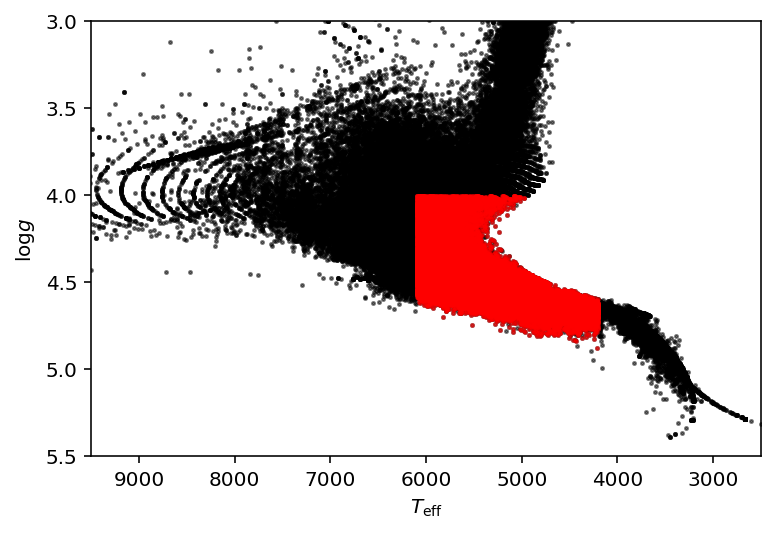

In [9]:
# Plot an HR diagram of the selected targets


pl.plot(base_stlr.teff, base_stlr.logg, ".k", ms=3, alpha=0.5)
pl.plot(stlr.teff, stlr.logg, ".r", ms=3, alpha=0.5)
pl.xlim(9500, 2500)
pl.ylim(5.5, 3)
pl.ylabel("$\log g$");
pl.xlabel("$T_\mathrm{eff}$");


In [10]:
%%time
# !!!!! Get the planet catalog and make selection cuts 

if(catalogSwitch == "1"):
    # !!!!! Q1-Q16 planet catalog (9.1 pipeline)
    kois = get_catalog("q1_q16_koi")

elif(catalogSwitch == "2"):
    # !!!!! Q1-Q17 DR24 (9.2 pipeline)
    kois = get_catalog("q1_q17_dr24_koi")

elif(catalogSwitch == "3"):
    # !!!!! Q1-Q17 DR25 (9.3 pipeline)
    kois = get_catalog("q1_q17_dr25_koi")

# Set insolation (or period) and planet radius ranges
# for power law fit
rp_rng = (0.75, 2.5)
if(periodInsolationSwitch=="I"):
    x_rng = (0.2, 20)
elif(periodInsolationSwitch=="P"):
    x_rng = (50, 300)

# Join on the stellar list.
kois = pd.merge(kois, stlr[["kepid"]], on="kepid", how="inner")

# Only select the KOIs in the relevant part of parameter space.
m = kois.koi_pdisposition == "CANDIDATE"
base_kois = pd.DataFrame(kois[m])

# Select planets based on either insolation or period
if(periodInsolationSwitch=='I'):
    # Select based on insolation range instead of period range
    m &= (x_rng[0] <= kois.koi_insol) & (kois.koi_insol <= x_rng[1])
elif(periodInsolationSwitch=='P'):
    # Select based on period range instead of insolation range
    m &= (x_rng[0] <= kois.koi_period) & (kois.koi_period <= x_rng[1])

# Select planet radius range
m &= np.isfinite(kois.koi_prad) & (rp_rng[0] <= kois.koi_prad) & (kois.koi_prad <= rp_rng[1])

# !!!!! Only include PCs with MES > 15 for 9.2 (Q1-Q17 Dr24)
# !!!!! For 9.1 (Q1-Q16) -- all max_mult_ev seem to be NaNs
if(catalogSwitch == "2"):
    m &= kois.koi_max_mult_ev > 15

# Panda data frame for selected kois
# Note that kois now contains only the selected planet candidates
kois = pd.DataFrame(kois[m])

#print("min insolation = {0} ".format(np.min((kois.koi_insol))))
#print("max insolation = {0} ".format(np.max((kois.koi_insol))))
#print(kois.koi_insol)


print("min period = {0} ".format(np.min(kois.koi_period)))
print("max period = {0} ".format(np.max(kois.koi_period)))
print("Selected {0} KOIs after cuts".format(len(kois)))


min period = 51.0674355 
max period = 295.958914 
Selected 147 KOIs after cuts
CPU times: user 169 ms, sys: 70.3 ms, total: 239 ms
Wall time: 308 ms


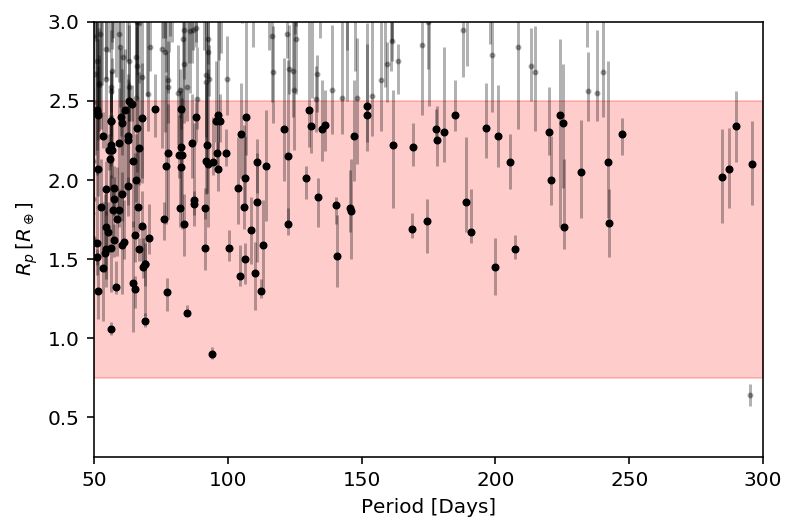

In [11]:
# Plot the measurements with error bars, in insolation-radius parameter space
yerr = np.abs(np.array(base_kois[["koi_prad_err2", "koi_prad_err1"]])).T

if(periodInsolationSwitch=="I"):
    pl.xlabel("insolation [Earth units]")
    pl.errorbar(base_kois.koi_insol, base_kois.koi_prad, yerr=yerr, fmt=".k", ms=4,
            capsize=0, alpha=0.3)
    pl.plot(kois.koi_insol, kois.koi_prad, ".k", ms=6)
elif(periodInsolationSwitch=="P"):
    pl.xlabel("Period [Days]")
    pl.errorbar(base_kois.koi_period, base_kois.koi_prad, yerr=yerr, fmt=".k", ms=4,
            capsize=0, alpha=0.3)
    pl.plot(kois.koi_period, kois.koi_prad, ".k", ms=6)
pl.fill_between(x_rng, [rp_rng[1], rp_rng[1]], [rp_rng[0], rp_rng[0]], color="r", alpha=0.2)
pl.xlim(x_rng + 0.1 * np.array([-1, 1]))
pl.ylim(rp_rng + 0.5 * np.array([-1, 1]))


pl.ylabel("$R_p \, [R_\oplus]$");


In [12]:
#%%=========================================================
# Completeness model helper functions (radius and orbital period)


def get_duration(period, aor, e):
    """
    Equation (1) from Burke et al. This estimates the transit
    duration in the same units as the input period. There is a
    typo in the paper (24/4 = 6 != 4).
    
    :param period: the period in any units of your choosing
    :param aor:    the dimensionless semi-major axis (scaled
                   by the stellar radius)
    :param e:      the eccentricity of the orbit
    
    """
    return 0.25 * period * np.sqrt(1 - e**2) / aor

def get_a(period, mstar, Go4pi=2945.4625385377644/(4*np.pi*np.pi)):
    """
    Compute the semi-major axis of an orbit in Solar radii.
    
    :param period: the period in days
    :param mstar:  the stellar mass in Solar masses
    
    """
    return (Go4pi*period*period*mstar) ** (1./3)

def get_delta(k, catalogSwitch, c=1.0874, s=1.0187):
    """
    Estimate the approximate expected transit depth as a function
    of radius ratio. There might be a typo here. In the paper it
    uses c + s*k but in the public code, it is c - s*k:
    https://github.com/christopherburke/KeplerPORTs
    
    :param k: the dimensionless radius ratio between the planet and
              the star
    
    """
    delta_max = k*k * (c + s*k)
    
    if(catalogSwitch == '1'):
        maxDepth = 0.84*delta_max
        # !!!!! For Q1-Q16 (9.1 pipeline) DFM used a multiplier 0f 0.84 instead of 1.0 in the equation below
        # return 0.84*delta_max
    elif(catalogSwitch == '2'):
        # !!!!! for Q1-Q17 DR24 (9.2 pipeline), use a multiplier of 1
        #return 1.0* delta_max
        maxDepth = 1.0*delta_max
    elif(catalogSwitch == '3'):
        # !!!!! for Q1-Q17 DR25 (9.3 pipeline), use a multiplier of 1
        #return 1.0* delta_max
        maxDepth = 1.0*delta_max
    
    return maxDepth

# 14 pulse durations
cdpp_cols = [k for k in stlr.keys() if k.startswith("rrmscdpp")]
cdpp_vals = np.array([k[-4:].replace("p", ".") for k in cdpp_cols], dtype=float)

def get_mes(star, period, rp, tau, catalogSwitch, re=0.009171):
    """
    Estimate the multiple event statistic value for a transit.
    
    :param star:   a pandas row giving the stellar properties
    :param period: the period in days
    :param rp:     the planet radius in Earth radii
    :param tau:    the transit duration in hours
    
    """
    # Interpolate the RMS CDPP corresponding to the transit duration.
    cdpp = np.array(star[cdpp_cols], dtype=float)
    sigma = np.interp(tau, cdpp_vals, cdpp)

    # Compute the radius ratio and estimate the S/N.
    k = rp * re / star.radius
    snr = get_delta(k, catalogSwitch) * 1e6 / sigma
    
    # Scale by the estimated number of transits.
    ntrn = star.dataspan * star.dutycycle / period 
    return snr * np.sqrt(ntrn)

# Pre-compute and freeze the gamma function from Equation (5) in
# Burke et al.

# Parameters gamma function model of detection efficiency vs. MES curve
if(catalogSwitch == '1'):
    # !!!!! Q1-Q16 (9.1 pipeline): DFM used the parameters below (GK stars)
     pgam = gamma(4.65, loc=0., scale=0.98)
    # But the parameters for FGK are (4.35, 0, 1.05) according to astro-ph 1507.05097 (Christiansen)
    #pgam = gamma(4.35, loc=0., scale=1.05)
    
elif(catalogSwitch == '2'):
    # !!!!! Parameters for 9.2 pipeline Q1-Q17 DR24 are from Jessie Christiansen
    # Note that these parameters do not apply to M stars!
    pgam = gamma(103.0113, loc=0., scale=0.10583)

elif(catalogSwitch == '3'):
    # DR25, 9.3
    pgam = gamma(a=30.87, loc=0., scale=0.271)

    
# mesthres_cols are column names for the 14 pulse durations
mesthres_cols = [k for k in stlr.keys() if k.startswith("mesthres")]

# pulse_durations_obs are the 14 pulse durations
pulse_durations_obs = np.array([k[-4:].replace("p", ".") for k in mesthres_cols],
                         dtype=float)
def get_pdet(star, aor, period, rp, e, catalogSwitch):
    """
    Equation (5) from Burke et al. Estimate the detection efficiency
    for a transit.
    
    :param star:   a pandas row giving the stellar properties
    :param aor:    the dimensionless semi-major axis (scaled
                   by the stellar radius)
    :param period: the period in days
    :param rp:     the planet radius in Earth radii
    :param e:      the orbital eccentricity
    
    """
    # mest is the interpolated MES threshold corresponding to the transit duration
    # tau is the pulse duration
    # pulse_durations_obs are the 14 pulse durations
    # np.array(star[mesthres_cols],dtype=float) are the coresponding MES thresholds
    tau = get_duration(period, aor, e) * 24.
    mes = get_mes(star, period, rp, tau, catalogSwitch)
    mest = np.interp(tau, pulse_durations_obs,
                     np.array(star[mesthres_cols],
                              dtype=float))
    
    # Gamma Parameters for detection efficiency vs. MES model
    if(catalogSwitch == "1"):
        # !!!!! For the 9.1 data
        # return pgam.cdf(x)        
        x = mes - 4.1 - (mest - 7.1)
        gammaParams = pgam.cdf(x)
        
    elif(catalogSwitch == "2"):
        # !!!!! DFM originally used no multiplier in the equation below;
        # The multiplier of 0.78442 must be a 'plateau factor' from Jessie, for 9.2
        # for the 9.2 Q1-Q17 DR24 data, provided by Jessie
        x = mes - 4.1 - (mest - 7.1)
        gammaParams = 0.78442*pgam.cdf(x)
    
    elif(catalogSwitch == "3"):
        # for the 9.3 Q1-Q17 DR25 data
        x = mes - (mest - 7.1)
        gammaParams = 0.94*pgam.cdf(x)
   
    return gammaParams


def get_pwin(star, period):
    """
    Equation (6) from Burke et al. Estimates the window function
    using a binomial distribution.
    
    :param star:   a pandas row giving the stellar properties
    :param period: the period in days
    
    """
    M = star.dataspan / period
    f = star.dutycycle
    omf = 1.0 - f
    pw = 1 - omf**M - M*f*omf**(M-1) - 0.5*M*(M-1)*f*f*omf**(M-2)
    msk = (pw >= 0.0) * (M >= 2.0)
    return pw * msk

def get_pgeom(aor, e):
    """
    The geometric transit probability.
    
    See e.g. Kipping (2014) for the eccentricity factor
    http://arxiv.org/abs/1408.1393
    
    :param aor: the dimensionless semi-major axis (scaled
                by the stellar radius)
    :param e:   the orbital eccentricity

    """
    return 1. / (aor * (1 - e*e)) * (aor > 1.0)


In [13]:
#%% This cell contains functions and code for calculating completeness in the
#       parameter space of [ insolation or Period , planet radius ] 
    
    
# Compute completeness grid for period vs radius
def get_completeness(star, period, rp, e, catalogSwitch,with_geom=True):
    """
    A helper function to combine all the completeness effects.
    
    :param star:      a pandas row giving the stellar properties (each row is for one star)
    :param period:    the period in days 
    :param rp:        the planet radius in Earth radii
    :param e:         the orbital eccentricity
    :param with_geom: include the geometric transit probability
    
    """
    aor = get_a(period, star.mass) / star.radius
    pdet = get_pdet(star, aor, period, rp, e, catalogSwitch)
    pwin = get_pwin(star, period)
    if not with_geom:
        return pdet * pwin
    pgeom = get_pgeom(aor, e)
    return pdet * pwin * pgeom
    #print(len(rp))

# Construct grid for planet radius
rp2 = np.linspace(rp_rng[0], rp_rng[1], 61)

if(periodInsolationSwitch == "P"):

    # Period grid
    period = np.linspace(x_rng[0], x_rng[1], 57)
    xLinearGrid = period
    x_grid, rp_grid2 = np.meshgrid(period, rp2, indexing="ij")


elif(periodInsolationSwitch == "I"):

    # Construct grid for insolation
    insolation = np.linspace(x_rng[0], x_rng[1], 57)
    xLinearGrid = insolation
    x_grid, rp_grid2 = np.meshgrid(insolation, rp2, indexing="ij")

# Compute completeness grid for insolation vs radius
def get_completeness_from_insolation(star, insolation_grid, rp_grid2, e, catalogSwitch, with_geom=True):
    
    # compute the periods corresponding to an insolation grid
    insolation = insolation_grid
    period_grid = get_period_from_insolation( star , insolation )
    
    # completeness 
    completeness = get_completeness(star, period_grid, rp_grid2, e, catalogSwitch, with_geom=True)
    
    return completeness
    
# Compute insolation on the period grid, for a given star 
def get_insolation_from_period( star , period ):
    
    # Get needed stellar parameters
    teffStar = star.teff
    teffSun = 5777
    rStar = star.radius
    mStar = star.mass
    
    # Semimajor axis of planet in AU
    aPlanet = mStar**(1.0/3.0) * (period/365.25)**(2.0/3.0) 
    
    # Compute insolation
    insolation = (teffStar/teffSun)**4*(rStar/1)**2*(1/aPlanet)**2
    
    return insolation

# Compute period on the insolation grid, for a given star
def get_period_from_insolation( star , insolation ):
    
    # Get needed stellar parameters
    teffStar = star.teff
    teffSun = 5777
    rStar = star.radius
    mStar = star.mass
    
    # Get semimajor axis from star properties and insolation, using
    # insolation = ( teffStar / teffSun )**4 * ( rStar / 1)**2 * ( 1 / aPlanet )**2
    aPlanet = ( ( teffStar / teffSun )**4 * ( rStar / 1)**2 / insolation )**(0.5)
    
    # Get orbit period in days from semimajor axis of planet in AU and start properties, using
    # aPlanet = mStar**(1.0/3.0) * (period/365.25)**(2.0/3.0)
    period = 365.25 * ( aPlanet/( mStar**(1.0/3.0) ) )**(3.0/2.0)
    
    return period



In [14]:
%%time
# Marginalize detection contours over all selected targets
# including the geometric factor. This takes a few minutes.
new_completeness = np.zeros_like(x_grid)
if(periodInsolationSwitch == "P"):
    for _, star in stlr.iterrows():
        new_completeness += get_completeness(star, x_grid, rp_grid2, 0.0, catalogSwitch, with_geom=True)
elif(periodInsolationSwitch == "I"):
    for _, star in stlr.iterrows():
        new_completeness += get_completeness_from_insolation(star, x_grid, rp_grid2, 0.0, catalogSwitch, with_geom=True)



CPU times: user 4min 56s, sys: 1.2 s, total: 4min 57s
Wall time: 4min 59s


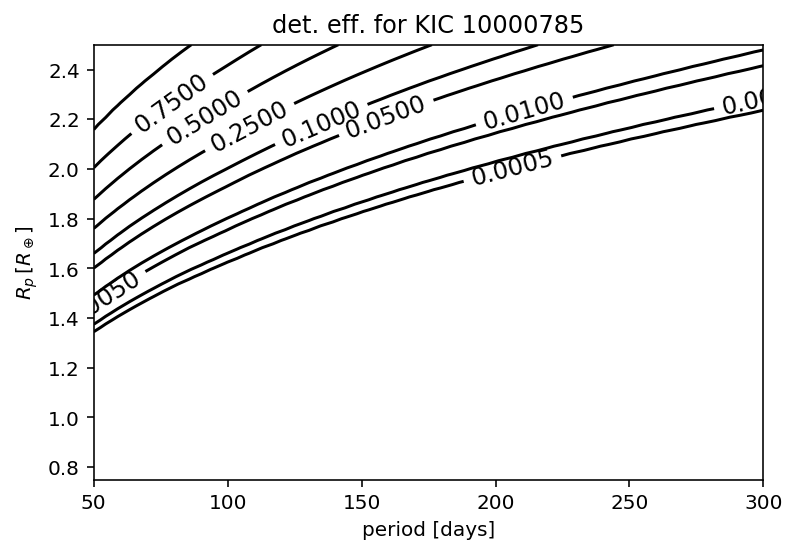

In [15]:
# Reproducing Figure 1 from Burke paper, which is the
# completeness contour (not including geometric effect) for an example target
 
# Option for new insolation completeness.  
    
# Choose the first star
star = stlr[stlr.kepid == stlr.kepid.iloc[0]].iloc[0]

# Compute the completeness map on a grid.
X, Y = x_grid, rp_grid2 

if(periodInsolationSwitch == "P"):
    Z = get_completeness(star, X, Y, 0.0, catalogSwitch, with_geom=False)

elif(periodInsolationSwitch == "I"):
    Z = get_completeness_from_insolation(star, X, Y, 0.0, catalogSwitch, with_geom=False)

# Plot with the same contour levels as the figure. Add some contours at low end of completeness.
c = pl.contour(X, Y, Z, [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99], colors="k")
pl.clabel(c, fontsize=12, inline=1, fmt="%.4f") 

if(periodInsolationSwitch == "I"):
    pl.xlabel("insolation [Earth units]")
elif(periodInsolationSwitch == "P"):
    pl.xlabel("period [days]")

pl.ylabel("$R_p \, [R_\oplus]$")
pl.title("det. eff. for KIC {0}".format(np.min(stlr.kepid.iloc[0])));


0.0148659917878
4.95150759976e-06


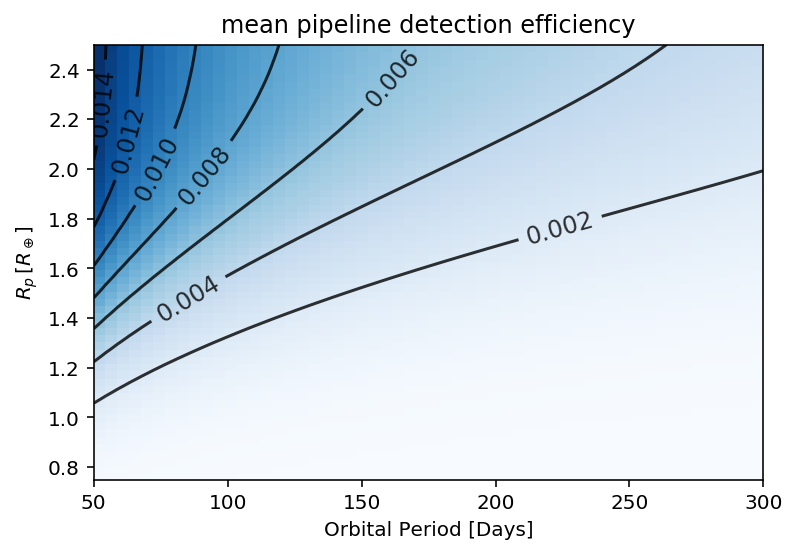

In [16]:
#%%=========================================================
# Plot the average new_completeness contour (radius-period or radius-insolation)
# Include the geometric effect
pl.pcolor(x_grid, rp_grid2, new_completeness, cmap="Blues")
c = pl.contour(x_grid, rp_grid2, new_completeness / len(stlr),
               colors="k", alpha=0.8)
pl.clabel(c, fontsize=12, inline=1, fmt="%.3f")
pl.title("mean pipeline detection efficiency")
# 10.3.17, fixed to Orbital Period at beginning of notebook.
pl.xlabel("Orbital Period [Days]")
#pl.xlabel("insolation [Earth units]")
pl.ylabel("$R_p \, [R_\oplus]$");

print(np.max(new_completeness/len(stlr)))
print(np.min(new_completeness/len(stlr)))

In [17]:
# Population inference with an independent power law model
# Using modified code above that computes 
# completeness in the parameter space of [ period or insolation , planet radius ], 

# A double power law model for the population. 
# xLinerGrid is Period or Insolation grid. 
def population_model(theta, xLinearGrid, rp):
    # Parameters 
    # lnf0 is normalization, 
    # beta is exponent of insolation power law,
    # alpha is exponent of radius power law
    lnf0, beta, alpha = theta
    v = np.exp(lnf0) * np.ones_like(xLinearGrid)
    for x, rng, n in zip((xLinearGrid, rp),
                         (x_rng, rp_rng),
                         (beta, alpha)):
        n1 = n + 1
        v *= x**n*n1 / (rng[1]**n1-rng[0]**n1)
    return v


# The ln-likelihood function given at the top of this post.
# change to insolation from planet catalog using prompts at beginning of notebook.

# Period or Insolation, and radius for planets in catalog
if(periodInsolationSwitch == "P"):
    koi_x = np.array(kois.koi_period)
elif(periodInsolationSwitch == "I"):
    koi_x = np.array(kois.koi_insol)
    
koi_rps = np.array(kois.koi_prad)

# Parameter space volume in each bin of [period or insolation, radius] grid
# Note the bins are not uniformly spaced in period or insolation
vol = np.diff(x_grid, axis=0)[:, :-1] * np.diff(rp_grid2, axis=1)[:-1, :]
def lnlike(theta):
    pop = population_model(theta, x_grid, rp_grid2) * new_completeness
    pop = 0.5 * (pop[:-1, :-1] + pop[1:, 1:])
    norm = np.sum(pop * vol)
    #print(norm)
    ll = np.sum(np.log(population_model(theta, koi_x, koi_rps))) - norm
    return ll if np.isfinite(ll) else -np.inf
# The ln-probability function is just proportional to the ln-likelihood
# since we're assuming uniform priors.
bounds = [(-5, 5), (-5, 5), (-5, 5)]
def lnprob(theta):
    # Broad uniform priors.
    for t, rng in zip(theta, bounds):
        if not rng[0] < t < rng[1]:
            return -np.inf
    return lnlike(theta)

# The negative ln-likelihood is useful for optimization.
# Optimizers want to *minimize* your function.
def nll(theta):
    ll = lnlike(theta)
    return -ll if np.isfinite(ll) else 1e15



In [18]:
%%time
# Maximum likelihood solution by minimizing negative log-likelihood
# Initial guess for logF, beta, and alpha
theta_0 = np.array([1, 0.66, -1.5])
#DFM original initial values below
#theta_0 = np.array([np.log(0.75), -0.53218, -1.5])

r = minimize(nll, theta_0, method="L-BFGS-B", bounds=bounds)
print(r)
# r.x is the vector of parameters (logF, beta, and alpha) from the maximum likelihood solution


      fun: 1127.6922765010547
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00068212,  0.00015916,  0.00040927])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 60
      nit: 13
   status: 0
  success: True
        x: array([-0.89789235, -0.91537453, -0.22507034])
CPU times: user 106 ms, sys: 11 ms, total: 117 ms
Wall time: 142 ms


In [19]:

# Plot the maximum likelihood solution

# We'll reuse these functions to plot all of our results.

# This function plots the density of samples of a double power law,
# as a function of the x0 input, marginalized over the y input
def make_plot(pop_comp, x0, x, y, ax):
    # pop_comp is a two-dimensional array of completeness values
    # pop_comp.shape is 57(period or insolation) x 61(radius)  
    # x0 is: bin edges of second variable (radius), for model fitting
    # x is rebinning of x0 into a coarser grid for the plots
    # y is: bin edges of first variable (insolation), for model fitting
    # Mid-bin values of the 2D array pop_comp, along the first dimension -- insolation
    pop = 0.5 * (pop_comp[:, 1:] + pop_comp[:, :-1])
    # on first call, pop is 56 x 61

    # Integrate completeness over the first variable, y, period or insolation
    # np.diff(y)[None, :, None] is the parameter space interval in y
    pop = np.sum(pop * np.diff(y)[None, :, None], axis=1)
    # After above command, pop is 1D, collapsed onto the radius dimension
    
    # Credible regions in x: radius
    # x is used only to get the parameter space interval dx in radius for the plot
    # Note: Assumes bin spacing np.diff(x) is uniform
    a, b, c, d, e = np.percentile(pop * np.diff(x)[0], [2.5, 16, 50, 84, 97.5], axis=0)
    # print(c)

    ax.fill_between(x0, a, e, color="k", alpha=0.1, edgecolor="none")
    ax.fill_between(x0, b, d, color="k", alpha=0.3, edgecolor="none")
    # c is the median value of the distribution over 
    ax.plot(x0, c, "k", lw=1)

def plot_results(samples):
    # Loop through the samples and compute the list of population models.
    samples = np.atleast_2d(samples)
    
    # print(samples.shape)
    # print(len(samples))
    # len(samples) is the length of the MCMC chain
    pop = np.empty((len(samples), x_grid.shape[0], x_grid.shape[1]))
    gamma_earth = np.empty((len(samples)))
    for i, p in enumerate(samples):
        # insolation or period _grid and rp_grid2 are meshgrids, 57x61
        # print(p)
        # print(rp_grid2.shape)
        # print(insolation_grid.shape)
        # print(i)
        # power law planet density on period or insolation, radius grid
        pop[i] = population_model(p, x_grid, rp_grid2)
        # planet density at the point corresponding to earth (insolation = 1 and radius = 1)
        #gamma_earth[i] = population_model(p, 1.0, 1.0) * 1.0 
        gamma_earth[i] = population_model(p, 365.25, 1.0) * 365.
        # print(gamma_earth[i])
        
    # Set up 4x4 grid of plots
    fig, axes = pl.subplots(2, 2, figsize=(10, 8))
    fig.subplots_adjust(wspace=0.4, hspace=0.4)
    
    # Histogram of planet radius over a new grid
    # Using a coarser grid for the plot
    dx = 5*(rp2[1] - rp2[0])
    x = np.arange(rp_rng[0], rp_rng[1] + dx, dx)
    n, _ = np.histogram(koi_rps, x)
    
    # Plot the predicted radius distribution against the observed radius distribution
    ax = axes[0, 0]
    
    # Predicted radius distribution
    # rp2 is of length 61
    # nsolation is of length 57
    # pop is 57 x 61 -- so it's insolation x radius
    # new_completeness is 1 x 57 x 61
    make_plot(pop * new_completeness[None, :, :], rp2, x, xLinearGrid, ax)
    
    # Observed radius distribution, with Poisson errors
    ax.errorbar(0.5*(x[:-1]+x[1:]), n, yerr=np.sqrt(n), fmt=".k",
                capsize=0)
    ax.set_xlim(rp_rng[0], rp_rng[1])
    ax.set_xlabel("$R_p\,[R_\oplus]$")
    ax.set_ylabel("# of detected planets")
    
    # Plot the true radius distribution.
    ax = axes[0, 1]
    make_plot(pop, rp2, x, xLinearGrid, ax)
    ax.set_xlim(rp_rng[0], rp_rng[1])
    # ax.set_ylim(0, 0.37)
    ax.set_xlabel("$R_p\,[R_\oplus]$")
    ax.set_ylabel("$\mathrm{d}N / \mathrm{d}R$; $\Delta R = 0.25\,R_\oplus$")
    
    # Histogram of insolation or period over a new grid.
    # Using a coarser grid for the plot
    dx = 5*(xLinearGrid[1] - xLinearGrid[0])
    
    x = np.arange(x_rng[0], x_rng[1] + dx, dx)
    n, _ = np.histogram(koi_x, x)
    
    # Plot the predicted insolation distribution against the observed insolation distribution
    ax = axes[1, 0]
    
    # Predicted insolation or period distribution
    make_plot(np.swapaxes(pop * new_completeness[None, :, :], 1, 2), xLinearGrid, x, rp2, ax)
    
    # Observed insolation or period distribution, with Poisson errors
    ax.errorbar(0.5*(x[:-1]+x[1:]), n, yerr=np.sqrt(n), fmt=".k",
                capsize=0)
    # ax.set_xlim(insolation_rng[0], insolation_rng[1])
    ax.set_xlim(0.5, x_rng[1])
    # ax.set_ylim(0, 25)
    ax.set_ylim(0, 40)
    
    if(periodInsolationSwitch=='I'):
        ax.set_xlabel("insolation, [Earth units]")
    elif(periodInsolationSwitch=='P'):
        ax.set_xlabel("period, [Days]")


    ax.set_ylabel("# of detected planets")
    
    # Plot the true insolation distribution.
    ax = axes[1, 1]
    make_plot(np.swapaxes(pop, 1, 2), xLinearGrid, x, rp2, ax)
    ax.set_xlim(x_rng[0], x_rng[1])
    
    if(periodInsolationSwitch=='I'):
        ax.set_ylabel("$\mathrm{d}N / \mathrm{d}I$; $\Delta I = $")
        ax.set_xlabel("insolation, [Earth units]")

    elif(periodInsolationSwitch=='P'):
        ax.set_ylabel("$\mathrm{d}N / \mathrm{d}P$; $\Delta P = 31.25\,\mathrm{days}$")
        ax.set_xlabel("period, [Days]")

    return gamma_earth



[ 0.15638016]
CPU times: user 173 ms, sys: 12.8 ms, total: 186 ms
Wall time: 179 ms


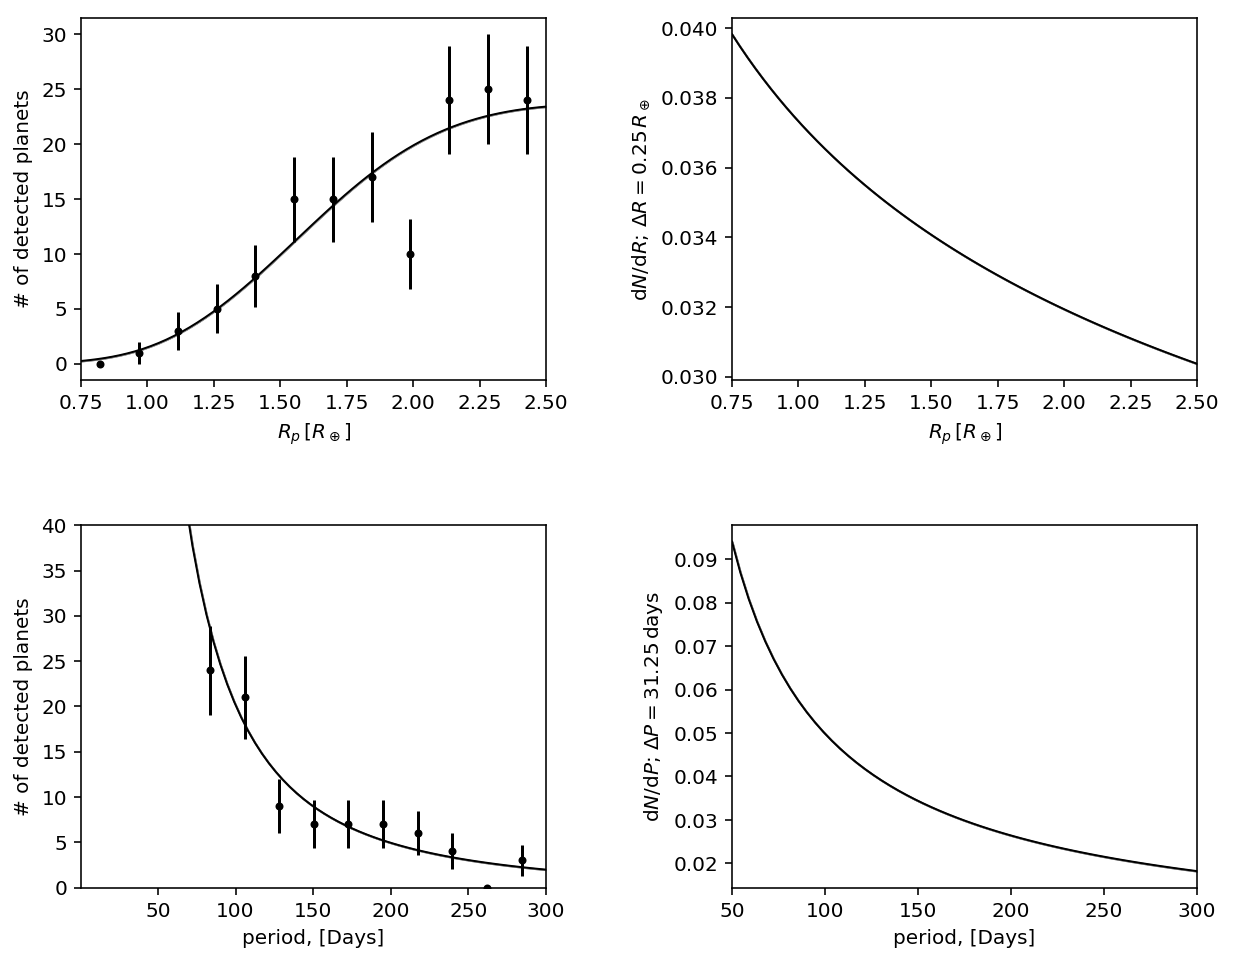

In [20]:
%%time
# This line calls the plotting machinery above, and returns the maximum likelihood value of gamma_earth
# Note that r.x is the set of parameters [ lnf0, beta, alpha ] returned by the maximum likelihood fit
print(plot_results(r.x));

# Or, try your own values for the parameters
# thetaTry = np.array([.01, -1.2, -1.1])
# print(plot_results(thetaTry));

In [21]:
%%time

# Sample from the posterior probability distribution for the population parameters using emcee

ndim, nwalkers = len(r.x), 16

# Initialize, and set trial vector as Max Likelihood solution perturbed by a small random vector
pos = [r.x + 1e-5 * np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

# specify number of samples and number of burn-in samples
nSamplesPerChain = 4000
nBurnIn = nSamplesPerChain/4
nChains = nwalkers

# Burn in.
pos, _, _ = sampler.run_mcmc(pos, nBurnIn)
sampler.reset()

# Production.
pos, _, _ = sampler.run_mcmc(pos, nSamplesPerChain)



CPU times: user 34.3 s, sys: 403 ms, total: 34.7 s
Wall time: 35.9 s


CPU times: user 511 ms, sys: 15 ms, total: 526 ms
Wall time: 613 ms


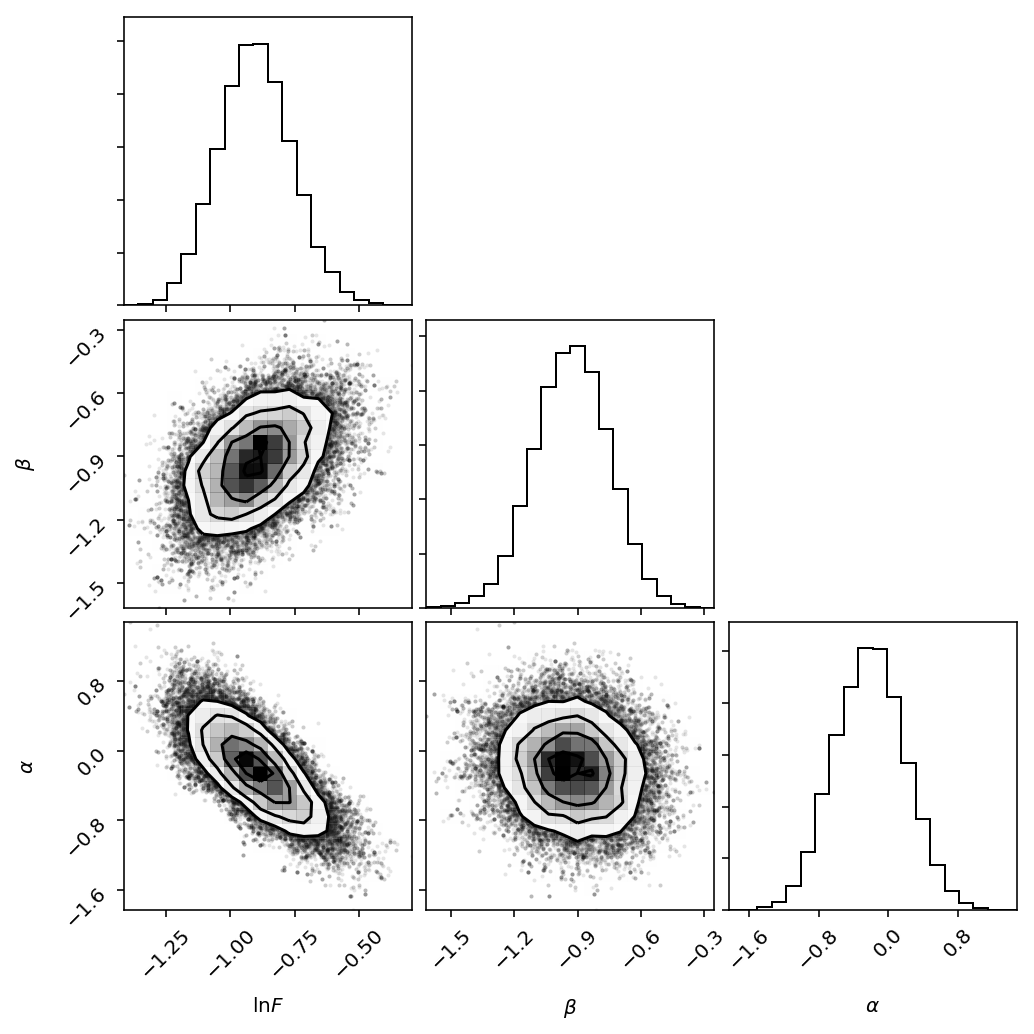

In [22]:
%%time
# Triangle plot of PDFs using DFMs corner package
fig = corner.corner(sampler.flatchain, labels=[r"$\ln F$", r"$\beta$", r"$\alpha$"]);


CPU times: user 1.88 s, sys: 499 ms, total: 2.37 s
Wall time: 2.6 s


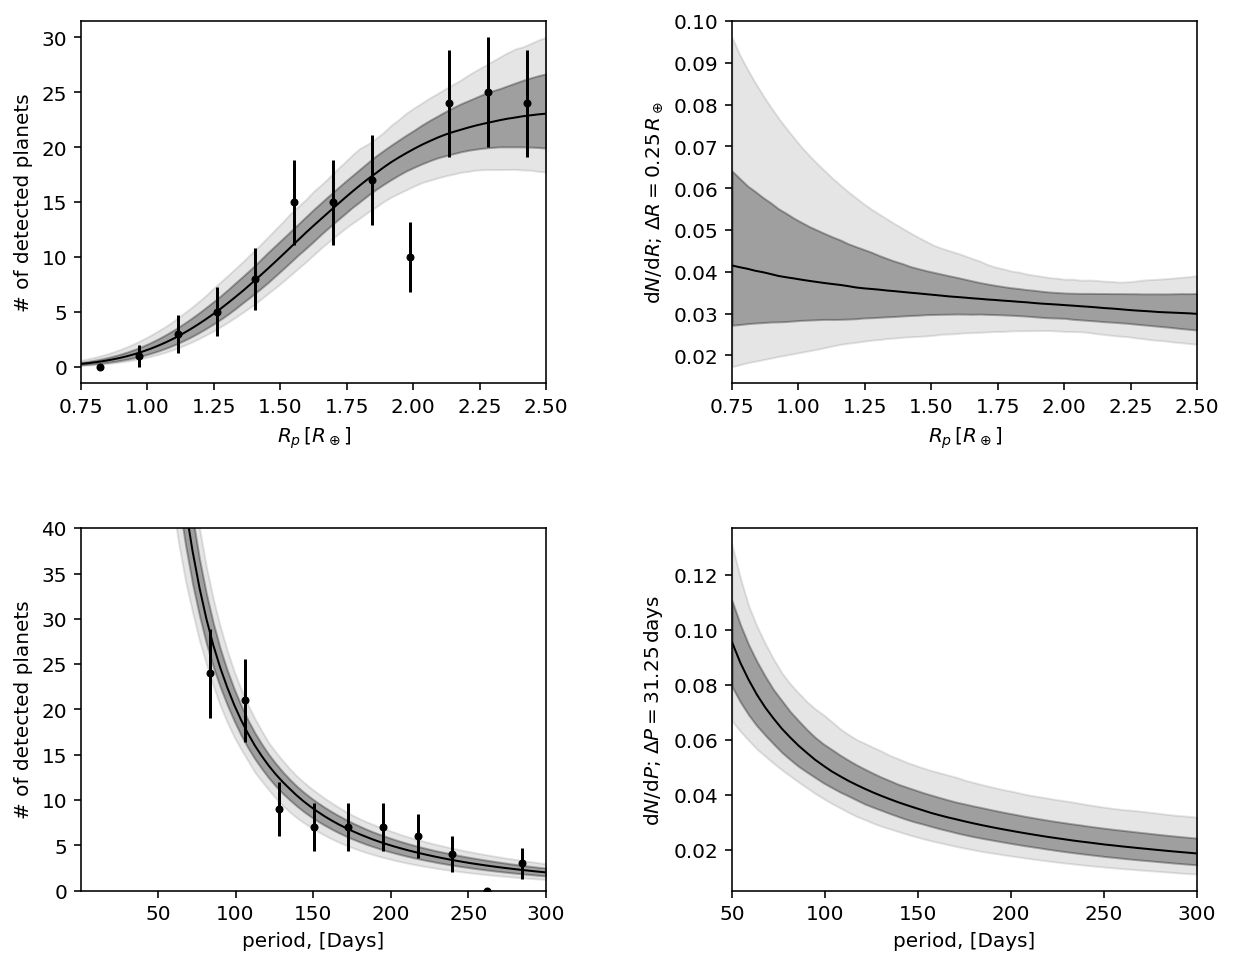

In [23]:
%%time
# Plot marginalized posteriors of N and dN/dR
# For Rp, marginalize over P
# For P, marginalize over Rp
# For N, plot also the data and the error bars

# Plot only the last 4000 iterations 
gamma_earth = plot_results(sampler.flatchain[60000:63999,:])


CPU times: user 47.6 ms, sys: 7.9 ms, total: 55.5 ms
Wall time: 49.4 ms


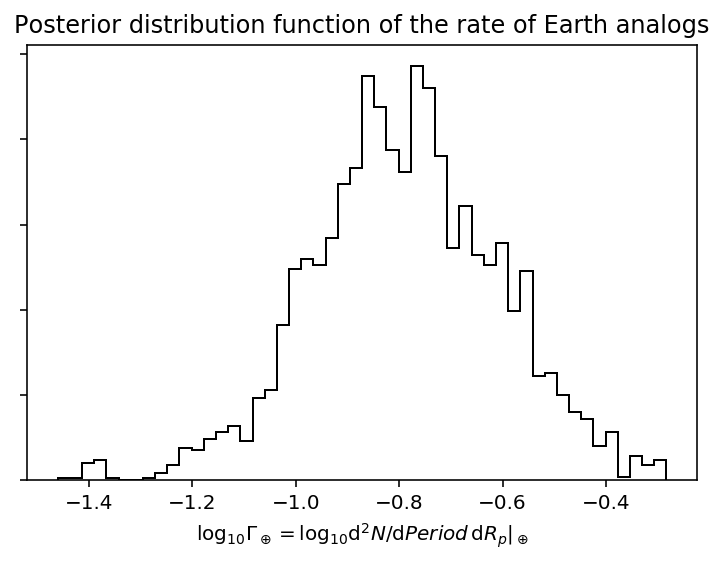

In [24]:
%%time
# Posterior distribution of log10 gamma_earth
pl.hist(np.log10(gamma_earth), 50, histtype="step", color="k")
pl.gca().set_yticklabels([])
pl.title("Posterior distribution function of the rate of Earth analogs")
# pl.xlabel(r"$\log_{10}\Gamma_\oplus $");

if(periodInsolationSwitch == 'I'):
    pl.xlabel(r"$\log_{10}\Gamma_\oplus = \left. \log_{10}\mathrm{d}^2 N / \mathrm{d} Insolation \, \mathrm{d} R_p \right |_\oplus$");
elif(periodInsolationSwitch == 'P'):
    pl.xlabel(r"$\log_{10}\Gamma_\oplus = \left. \log_{10}\mathrm{d}^2 N / \mathrm{d} Period \, \mathrm{d} R_p \right |_\oplus$");


In [25]:
# Integrate the planet density over a given range in period or insolation and radius
#   to get the exoplanet occurrence rate predicted by the power law in that region

def integrated_gamma(theta,x1,x2,radius1,radius2,periodInsolationSwitch):
    
    # Break out parameters 
    lnf0, beta, alpha = theta
    
    # Phase space boundaries for our model
    if(periodInsolationSwitch == 'P'):
        x_rng = (50, 300)
    elif(periodInsolationSwitch == 'I'):
        x_rng = (0.2, 20)
            
    radius_rng = (0.75, 2.5)
    
    # Compute exoplanet occurrence rate integrated over chosen region of [ x , radius] parameter space
    integral_over_x = (x2**(beta + 1) - x1**(beta + 1))/(x_rng[1]**(beta + 1) - x_rng[0]**(beta + 1))
    integral_over_radius = (radius2**(alpha + 1) - radius1**(alpha + 1))/(radius_rng[1]**(alpha + 1) - radius_rng[0]**(alpha + 1))
    eta = integral_over_x*integral_over_radius*np.exp(lnf0)
    
    return eta
    

16, 50, 84 percentile range for integrated gamma = [ 0.35180228  0.40451465  0.46755222] 
CPU times: user 805 ms, sys: 73.7 ms, total: 879 ms
Wall time: 1.03 s


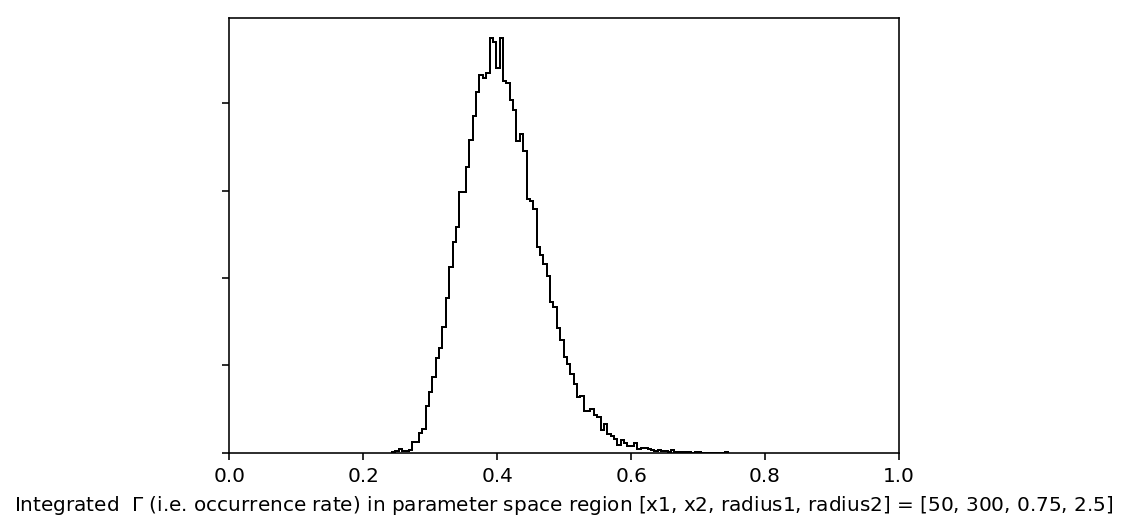

In [363]:
%%time
#  Compute and plot the posterior PDF for the exoplanet occurence rate in a 
#   desired region of period, radius parameter space
#   NOTE: using SAG-13 binning scheme

# Initialize   
int_gamma_samples = np.empty(len(sampler.flatchain))

# !!!!! Choose period or insolation bin edges (according to stellar type), for occurrence rate calculation
if(periodInsolationSwitch == 'I'):

    if(stellarTypeSwitch == 'A'):
        # Select A dwarfs
        # !!!!! Using same range as for G dwarfs, for now
        x1 = 0.295
        x2 = 1.824
        
    elif(stellarTypeSwitch == 'F'):
        # Select F dwarfs
        # !!!!! Using same range as for G dwarfs, for now
        x1 = 0.295
        x2 = 1.824

    elif(stellarTypeSwitch == 'G'):
        # Select G dwarfs
        x1 = 0.295
        x2 = 1.824
       
    elif(stellarTypeSwitch == 'K'):
        # Select K dwarfs
        x1 = 0.235
        x2 = 1.681

    elif(stellarTypeSwitch == 'M'):
        # Select M dwarfs
        x1 = 0.205
        x2 = 1.514

elif(periodInsolationSwitch == 'P'):
    
    #x1 = 160
    #x2 = 320
    x1=50
    x2=300

# !!!!! Choose radius bin edges for occurrence rate calculation
#radius1 = 1.0
#radius2 = 1.5
radius1 = .75
radius2 = 2.5

# Integrate the gamma posterior distribution over the selected phase space bin
# NOTE -- This gives the exoplanet occurrence rate in that phase space bin!
for i, theta in enumerate(sampler.flatchain):
    int_gamma_samples[i] = integrated_gamma(theta,x1,x2,radius1,radius2,periodInsolationSwitch)

# print occurrence rate for this parameter space region
print("16, 50, 84 percentile range for integrated gamma = {0} ".format(np.percentile(int_gamma_samples,[16,50,84])))

# Plot the posterior of int gamma_samples over selected planet radius and period range             
pl.hist(int_gamma_samples, 100, histtype="step", color="k")
pl.gca().set_yticklabels([])
if(periodInsolationSwitch == 'I'):
    pl.title("Integrated ocurrence rate over radius and insolation")
elif(periodInsolationSwitch == 'I'):
    pl.title("Integrated ocurrence rate over radius and period")
    
pl.xlabel(r"Integrated  $\Gamma$ (i.e. occurrence rate) in parameter space region [x1, x2, radius1, radius2] = {0}".format([x1,x2,radius1,radius2]));    
# pl.xlabel(r"$\log_{10}\Gamma_\oplus = \left. \log_{10}\mathrm{d}N / \mathrm{d}\ln P \, \mathrm{d}\ln R_p \right |_\oplus$");
pl.xticks
pl.gca().set_xlim([0,1])

In [356]:
%%time
# Gather and save occurrence rate data for emcee sampler
# Could make this a function which takes as inputs
# the posterior samples array 
# the names of the files to save to
# nSamplesPerChain
# nChains
samples = sampler.flatchain

# Define radius and period bin edges
radiusBinEdges = [0.67, 1.0, 1.5, 2.3, 3.4, 5.1, 7.6, 11, 17]
periodBinEdges = [10, 20, 40, 80, 160, 320, 640]

# Initialize dictionary
# occurrenceRateData = dict()

# Initialize lists for median, lower and upper occ rate limits
listMedian = [None]*(len(radiusBinEdges)-1)
listLowerCredibleInterval = [None]*(len(radiusBinEdges)-1)
listUpperCredibleInterval = [None]*(len(radiusBinEdges)-1)

# Loop over desired period and radius bins and compute occurrence rates
for iRadius in range(len(radiusBinEdges)-1):
    # Initialize lists for rows
    listMedianRow = []
    listLowerCredibleIntervalRow = []
    listUpperCredibleIntervalRow = []
    for iPeriod in range(len(periodBinEdges)-1):
        # Integrate the gamma posterior distribution over the selected phase space bin
        # NOTE -- This gives the exoplanet occurrence rate in that phase space bin
        int_gamma_samples = [None]*(len(samples))
        for i, theta in enumerate(samples):
            int_gamma_samples[i] = integrated_gamma(theta,periodBinEdges[iPeriod],periodBinEdges[iPeriod+1],
                                                   radiusBinEdges[iRadius],radiusBinEdges[iRadius+1],periodInsolationSwitch)

        # Print result for this bin
        print("\nRadius Bin "+str(radiusBinEdges[iRadius])+" to "+str(radiusBinEdges[iRadius+1])+" , Period Bin "+str(periodBinEdges[iPeriod])+" to "+str(periodBinEdges[iPeriod+1]))
        print("     Occurrence rate 16, 50, 84 percentile range : {0} ".format(np.percentile(int_gamma_samples,[16,50,84])))

        # Populate the dictionary with the result for this bin
        # binKey = "bin_" + str(radiusBinEdges[iRadius]) + "_" + str(periodBinEdges[iPeriod])
        # occurrenceRateData[binKey] = np.percentile(int_gamma_samples,[16,50,84])
        
        # Accumulate a row vector of median occurrence rates and their upper and lower credible intervals
        # for period bins at this radius
        listMedianRow.append(np.percentile(int_gamma_samples,[50]))
        listLowerCredibleIntervalRow.append(np.percentile(int_gamma_samples,[16]))
        listUpperCredibleIntervalRow.append(np.percentile(int_gamma_samples,[84]))
              
    # Append the row vector of results into the arrays for the median and lower and upper occ rate limits
    listMedian[iRadius] = listMedianRow
    listLowerCredibleInterval[iRadius] = listLowerCredibleIntervalRow
    listUpperCredibleInterval[iRadius] = listUpperCredibleIntervalRow
        
# Save the dictionary
#with open('occurrence_rate_data_'+stellarTypeSwitch+'_'+catalogSwitch+'.pkl', 'wb') as handle:
#    pickle.dump(occurrenceRateData, handle)
    
# Save the .csv files
np.savetxt('eta_emcee_occurrence_rate_median_'+str(nSamplesPerChain)+'_samples_per_chain_'+str(nChains)+'_chains_'+stellarTypeSwitch+'_'+catalogSwitch+'.csv', np.array(listMedian), delimiter=",",fmt='%.5f')
np.savetxt('sigma_n_emcee_occurrence_rate_lower_credible_interval_'+str(nSamplesPerChain)+'_samples_per_chain_'+str(nChains)+'_chains_'+stellarTypeSwitch+'_'+catalogSwitch+'.csv', np.array(listLowerCredibleInterval), delimiter=",",fmt='%.5f')
np.savetxt('sigma_p_emcee_occurrence_rate_upper_credible_interval_'+str(nSamplesPerChain)+'_samples_per_chain_'+str(nChains)+'_chains_'+stellarTypeSwitch+'_'+catalogSwitch+'.csv', np.array(listUpperCredibleInterval), delimiter=",",fmt='%.5f')




Radius Bin 0.67 to 1.0 , Period Bin 10 to 20
     Occurrence rate 16, 50, 84 percentile range : [ 0.01802332  0.02847418  0.04430377] 

Radius Bin 0.67 to 1.0 , Period Bin 20 to 40
     Occurrence rate 16, 50, 84 percentile range : [ 0.02029152  0.03002899  0.0436308 ] 

Radius Bin 0.67 to 1.0 , Period Bin 40 to 80
     Occurrence rate 16, 50, 84 percentile range : [ 0.02216049  0.03139038  0.04452773] 

Radius Bin 0.67 to 1.0 , Period Bin 80 to 160
     Occurrence rate 16, 50, 84 percentile range : [ 0.02310953  0.03293427  0.04723385] 

Radius Bin 0.67 to 1.0 , Period Bin 160 to 320
     Occurrence rate 16, 50, 84 percentile range : [ 0.02311889  0.03476346  0.05185515] 

Radius Bin 0.67 to 1.0 , Period Bin 320 to 640
     Occurrence rate 16, 50, 84 percentile range : [ 0.02252651  0.0365433   0.0586273 ] 

Radius Bin 1.0 to 1.5 , Period Bin 10 to 20
     Occurrence rate 16, 50, 84 percentile range : [ 0.02753988  0.0395194   0.05678761] 

Radius Bin 1.0 to 1.5 , Period Bin 20 to 40

<h2 align="center">Part 2 of notebook:  Calculate Planet Occurrence Rates using PyStan</h2> 
Begin to incorporate uncertainty. Starting with including uncertainty in Planet Radius after precomputing completeness. 

In [134]:
np.set_printoptions(threshold='nan')

#%%===============================================================================================
# Pre-compute some values to be used in the Stan model

# change to column major for PyStan version (overwrite old version here)

if(periodInsolationSwitch == "P"):
    # Period grid
    x_grid, rp_grid2 = np.meshgrid(period, rp2, indexing="xy")

elif(periodInsolationSwitch == "I"):
    # Construct grid for insolation
    x_grid, rp_grid2 = np.meshgrid(insolation, rp2, indexing="xy")

# Column names for RMS CDPP
cdpp_cols = [k for k in stlr.keys() if k.startswith("rrmscdpp")]

# Values of RMS CDPP corresponding the the 14 pulse durations for all selected stars (column)
# cdpp_obs = np.array(star[cdpp_cols], dtype=float) # <- for one row (one star) change star for stlr.
cdpp_obs_all = np.array(stlr[cdpp_cols], dtype=float)

# Values for the 14 pulse durations derived from the column names
pulse_durations_obs = np.array([k[-4:].replace("p", ".") for k in mesthres_cols],dtype=float)
nPulses = len(pulse_durations_obs)

# Column names for the 14 MES thresholds
mesthres_cols = [k for k in stlr.keys() if k.startswith("mesthres")]

# MES threshold values corresponding to the 14 pulse durations
mesthres_obs_all = np.array(stlr[mesthres_cols],dtype=float)
#print(mesthres_obs_all)                        
# mest <- np.interp(tau, pulse_durations_obs, mesthres_obs, dtype=float)
# x <- mes - 4.1 - (mest - 7.1);

if(periodInsolationSwitch == "P"):
    # Period grid
    x_rng = (50, 300)
    x_grid = np.linspace(x_rng[0], x_rng[1], 57)
    nxGrid = len(x_grid)

elif(periodInsolationSwitch == "I"):
    # Insolation grid
    x_rng = (0.2, 20)
    x_grid = np.linspace(x_rng[0], x_rng[1], 57)
    nxGrid = len(x_grid)

# Planet radius grid
planet_radius_rng = (0.75, 2.5)
planet_radius_grid = np.linspace(planet_radius_rng[0], planet_radius_rng[1], 61)
nRadiusGrid = len(planet_radius_grid)

# Make 2D meshgrids for bin edges.
planet_radius_grid_vol, x_grid_vol = np.meshgrid(planet_radius_grid, x_grid, indexing="xy")

# 2D grid of insolation-radius parameter space bin volumes at bin centers
vol = np.diff(x_grid_vol, axis=0)[:, :-1] * np.diff(planet_radius_grid_vol, axis=1)[:-1, :]
volShape = list(vol.shape)

# Stellar parameters (for all stars in the stellar catalog)
teffStar = stlr.teff
teffSun = 5777
rStar = stlr.radius
mStar = stlr.mass

# number of stars in the stellar catalog:
nStar = len(stlr)

# Insolation and radius for planets in the planet catalog
if(periodInsolationSwitch == "P"):
    koi_x = np.array(kois.koi_period)
elif(periodInsolationSwitch == "I"):
    koi_x = np.array(kois.koi_insol)

# Catalog radii of observed planets
koi_rps = np.array(kois.koi_prad)

# Catalog radius errors of observed planets
# Replace zeros of koi_rps_err1 with the minimum nonzero value of koi_rps_err1
koi_rps_err1 = np.array(kois.koi_prad_err1)
ind1Zero = np.where(koi_rps_err1 == 0)[0]
ind1NonZero = np.where(koi_rps_err1 != 0)[0]
koi_rps_err1[ind1Zero] = np.min(koi_rps_err1[ind1NonZero])

# Replace zeros of koi_rps_err2 with the negative minimum nonzero abs value of koi_rps_err2
koi_rps_err2 = np.array(kois.koi_prad_err2)
ind2Zero = np.where(koi_rps_err2 == 0)[0]
ind2NonZero = np.where(koi_rps_err2 != 0)[0]
koi_rps_err2[ind2Zero] = -np.min(np.abs(koi_rps_err2[ind1NonZero]))

# Number of planets selected from the KOI catalog
nKois = len(kois)

# Eccentricity is set to zero for now.
e = 0.0

# Dataspan is length of time between first and last observations of each star
star_dataspan = stlr.dataspan

# Dutycycle is the fraction of cadences with valid observations
star_dutycycle = stlr.dutycycle

# Upper and lower limits for uniform distribution
koi_rps_obs_lower = koi_rps + koi_rps_err2
koi_rps_obs_upper = koi_rps + koi_rps_err1
koi_rps_err_ave = (koi_rps_err1 + np.abs(koi_rps_err2))/2.

#subing in an artifically small radius uncertainty, 
koi_rps_err_ave_test = np.repeat(0.01, len(koi_rps_err_ave))


# Garbage collection
gc.isenabled()
gc.collect()



0

In [135]:
## Check that everything is there
#print(new_completeness.shape)
#print(cdpp_cols)
#print(len(cdpp_obs_all))
#print(len(pulse_durations_obs))
#print(mesthres_cols)
#print(len(mesthres_obs_all))
#print(nRadiusGrid)
#print(nxGrid)
#print(nPeriodGrid)
#print(nInsolationGrid)
#print(planet_radius_grid_vol.shape)
#print(x_grid_vol.shape)
#print(vol.shape)
print(nStar)
print(len(koi_x))
#print(len(koi_insolation))
print(len(koi_rps))
print(len(koi_rps_err1))
print(len(koi_rps_err2))
#print(nKois)
#print(planet_radius_rng)
#print(insolation_rng)
#print(x_rng)
#print(x_grid.shape)
#print(insolation_grid.shape)
#print(koi_rps_obs_lower)
print(np.hstack((koi_rps.reshape(-1,1) + koi_rps_err2.reshape(-1,1), koi_rps.reshape(-1,1), koi_rps.reshape(-1,1) + koi_rps_err1.reshape(-1,1))))
rp_err_down = koi_rps.reshape(-1,1) + koi_rps_err2.reshape(-1,1)
rp_err_up = koi_rps.reshape(-1,1) + koi_rps_err1.reshape(-1,1)
#print(koi_rps_err1)
#print(koi_rps_err2)
print("Checking average Rp err")
print(np.hstack((koi_rps_err_ave_test.reshape(-1,1), koi_rps_err1.reshape(-1,1),koi_rps_err2.reshape(-1,1),koi_rps_err_ave.reshape(-1,1))))

94732
147
147
147
147
[[ 2.28  2.37  2.54]
 [ 1.91  2.12  2.6 ]
 [ 1.62  1.75  1.86]
 [ 2.16  2.36  2.7 ]
 [ 2.01  2.39  2.74]
 [ 2.2   2.28  2.43]
 [ 2.05  2.17  2.24]
 [ 1.72  2.09  2.66]
 [ 2.03  2.43  3.17]
 [ 1.9   2.07  2.72]
 [ 1.94  2.13  2.41]
 [ 1.48  1.86  2.17]
 [ 1.49  1.71  1.93]
 [ 1.99  2.28  2.63]
 [ 2.24  2.4   2.49]
 [ 1.96  2.28  2.67]
 [ 1.64  1.81  1.94]
 [ 2.08  2.28  2.6 ]
 [ 1.87  2.22  2.58]
 [ 1.75  1.82  1.95]
 [ 2.17  2.34  2.43]
 [ 1.51  1.73  1.94]
 [ 1.82  2.01  2.28]
 [ 1.14  1.47  1.71]
 [ 1.53  1.63  1.85]
 [ 2.28  2.4   2.83]
 [ 1.07  1.11  1.16]
 [ 2.01  2.23  2.54]
 [ 1.33  1.39  1.59]
 [ 2.03  2.11  2.4 ]
 [ 1.76  2.05  2.38]
 [ 2.09  2.37  2.69]
 [ 2.11  2.3   2.84]
 [ 1.47  1.68  1.89]
 [ 1.27  1.45  1.63]
 [ 2.24  2.37  2.75]
 [ 0.87  0.9   0.94]
 [ 2.24  2.37  2.54]
 [ 1.92  2.11  2.26]
 [ 2.06  2.19  2.29]
 [ 1.78  1.88  2.02]
 [ 2.01  2.29  2.61]
 [ 2.32  2.45  2.56]
 [ 2.29  2.5   2.62]
 [ 1.7   1.81  1.94]
 [ 1.77  1.95  2.09]
 [ 2.25  2.4

In [257]:
%%time
!date
stan_model_occ = """

functions {

real[,] population_model_insolation(int nxGrid, int nRadiusGrid, 
real lnf0, real alpha, real beta, real[] x_grid, real[] planet_radius_grid, 
real[] planet_radius_rng, real[] x_rng) {

/* Population inference with an independent power law model
   Using modified code above that computes 
   completeness in the parameter space of [period or insolation , planet radius ], 

   A double power law model for the population.

   :param nxGrid: size of insolation grid
   :param nRadiusGrid: size of radius grid
   :param lnf0: normalization, 
   :param beta: exponent of insolation power law,
   :param alpha: exponent of radius power law
   :param x_grid:       //1D grid
   :param planet_radius_grid:    //1D grid
   :param x_rng: // lower and upper boundary values of insolation grid
   :param radius_rng:     // lower and upper boundary values of radius grid
   
*/    

// Declare internal variables
   real powerLawNumberDensity[nRadiusGrid,nxGrid];

// Loop over phase space bins, compute number density in each bin, 
//      from the power law using the input lnf0, alpha and beta parameters

    for (j in 1:nxGrid) 
       for (i in 1:nRadiusGrid) {

       powerLawNumberDensity[i,j] <- ( exp( lnf0 ) * ( alpha+1 ) * ( beta+1 ) * ( planet_radius_grid[i]^alpha ) * ( x_grid[j]^beta ) ) / ( ( planet_radius_rng[2]^( alpha+1 ) - ( planet_radius_rng[1]^( alpha+1 ) ) ) * ( ( x_rng[2]^( beta+1 ) ) - ( x_rng[1]^( beta+1 ) ) ) );
     }
   return powerLawNumberDensity;
}

real lnlike(real alpha, real beta, real lnf0, int nKois, real[] planet_radius_rng, 
real[] x_rng, real[,] vol, real[] x_grid, real[] planet_radius_grid, 
real[] koi_x, real[] koi_rps_true, int nRadiusGrid, int nxGrid, real e, real[,] new_completeness ) {

/* log likelihood function

    :param alpha:
    :param beta:
    :param lnf0:
    :param nKois
    :param planet_radius_rng
    :param x_rng
    :param vol:
    :param x_grid:
    :param planet_radius_grid:
    :param koi_x:
    :param koi_rps_true:
    :param nRadiusGrid
    :param nxGrid
    :param e
    :param new_completeness
        
*/

// Declare internal variables

    real pop[nRadiusGrid,nxGrid];
    real pop1[nRadiusGrid,nxGrid];
    real pop2[nRadiusGrid,nxGrid];
    real populationDensity[nRadiusGrid-1,nxGrid-1];
    real sumExpectedCounts;
    real logPop[nKois];
    real lnLikelihood;
    real sumLogPop;
    real lnLikelihood0;
    real popModelInsol0[nRadiusGrid,nxGrid];
    real popModelInsol[nKois,nKois];
    
     
    // Compute the population model for a grid over [ period or insolation, radius ] parameter space
    popModelInsol0 <- population_model_insolation(nxGrid, nRadiusGrid, lnf0, alpha, beta, x_grid, planet_radius_grid, planet_radius_rng, x_rng);

    // Compute the expected density of detections per bin in the [ period or insolation, radius ] parameter space,
    // based on the population model and the completeness
        for (i in 1:nRadiusGrid)
            for (j in 1: nxGrid) {

            //sum_completeness_0[i,j] <- new_completeness[j,i];
             pop[i,j] <- popModelInsol0[i,j] * new_completeness[j,i];

        }
        
    // Initialize
    sumExpectedCounts <- 0.0; 
    sumLogPop <-0.0;
    
    for (i in 1:nRadiusGrid-1)
      for (j in 1: nxGrid-1) {

      
         // Compute the number density of detections on a grid of bin centers
         
         // Figured out the proper syntax for translation of the Python line below into Stan
         // pop <- 0.5*(pop[:-1, :-1] + pop[1:, 1:]) is python syntax from DFM notebook.
         // Note that indices start with 1 in Stan
         pop1[i,j] <- pop[i,j];
         pop2[i,j] <- pop[i+1,j+1];
         populationDensity[i,j] <- 0.5*(pop1[i,j]+pop2[i,j]);
         
         // Integrate the planet counts over the phase space volume
         sumExpectedCounts <- sumExpectedCounts + (populationDensity[i,j]*vol[j,i]);
      }
   
   // Population model evaluated over the list of detected planets
   // 
   popModelInsol <- population_model_insolation(nKois, nKois, lnf0, alpha, beta, koi_x, koi_rps_true, planet_radius_rng, x_rng);

    for (k in 1:nKois) {
        logPop[k] <- log( popModelInsol[k,k] );
        sumLogPop <- sumLogPop + logPop[k];
    }
    
    // Combine the two terms to form the log-likelihood function for the Inhomogeneous Poisson Process 
    lnLikelihood <- sumLogPop - sumExpectedCounts;
    
    // Catch error: if lnLikelihood has bad value, return a very small number
    lnLikelihood0 <- if_else( is_inf(lnLikelihood) || is_nan(lnLikelihood) , -1e15, lnLikelihood );
    
   return lnLikelihood0;
   
} 

}
// end function block


data {

// Declare precomputed variables as data

int<lower=1> nKois;

int<lower=1> nRadiusGrid;

int<lower=1> nxGrid;

real x_rng[2]; 

real planet_radius_rng[2];

real x_grid[nxGrid];

real planet_radius_grid[nRadiusGrid];

real vol[nxGrid-1,nRadiusGrid-1];

real koi_x[nKois];

real koi_rps_obs[nKois];

real koi_rps_err1[nKois];

real koi_rps_err2[nKois];

real koi_rps_err_ave_test[nKois];

real koi_rps_obs_lower[nKois];

real koi_rps_obs_upper[nKois];

real e;

real new_completeness[nxGrid,nRadiusGrid];


}


parameters {

// For v1: only compute population level parameter posteriors.
    real<lower=-5,upper=5> alpha; 
    real<lower=-5,upper=5> beta;
    real<lower=-5,upper=5> lnf0;

// Ad hoc lower bound constraint on planet radius
    real<lower=0.2> koi_rps_true[nKois];
    //real<lower=0.0> koi_rps_true[nKois];
}

transformed parameters {

    
    //real<lower=-0.3> koi_rps_true_log10[nKois];
    //real<lower=0.0> ave_log10_sigma[nKois];
    

}
model {


    // Hyperpriors
    alpha ~ uniform(-5,5);
    beta ~ uniform(-5,5);
    lnf0 ~ uniform(-5,5);

    // Sample using lnLikelihood function
    increment_log_prob(lnlike(alpha, beta, lnf0, nKois, planet_radius_rng, x_rng, vol, x_grid, planet_radius_grid, koi_x, koi_rps_true, nRadiusGrid, nxGrid, e, new_completeness));

    for (n in 1:nKois)
        // first test symetric measurement uncertainty here:
        koi_rps_obs[n] ~ normal(koi_rps_true[n], koi_rps_err_ave_test[n]);
   
}


"""

# Compiled Stan Model
sm = StanModel(model_code=stan_model_occ)

!date




Thu Nov 30 23:22:05 PST 2017
Thu Nov 30 23:22:51 PST 2017
CPU times: user 1.83 s, sys: 314 ms, total: 2.14 s
Wall time: 46.2 s


In [258]:
%%time
!date

import generate_occ_rate_ICs

'''data = {'new_completeness':new_completeness, 'star_dutycycle':star_dutycycle, 'star_dataspan':star_dataspan, 
        'nStar':nStar, 'nKois':nKois,'nPulses':nPulses,'nRadiusGrid':nRadiusGrid, 'nxGrid':nxGrid, 
        'cdpp_obs_all':cdpp_obs_all, 'mesthres_obs_all':mesthres_obs_all, 'pulse_durations_obs':pulse_durations_obs, 
        'x_rng':x_rng, 'planet_radius_rng':planet_radius_rng,
        'x_grid':x_grid, 'planet_radius_grid':planet_radius_grid, 
        'vol':vol, 'teffStar':teffStar,'teffSun':teffSun, 'rStar':rStar, 'mStar':mStar,
        'koi_x':koi_x, 'koi_rps':koi_rps, 'e':e}
'''
data = {'new_completeness':new_completeness, 'nKois':nKois,'nRadiusGrid':nRadiusGrid, 'nxGrid':nxGrid, 
        'x_rng':x_rng, 'planet_radius_rng':planet_radius_rng,'x_grid':x_grid, 
        'planet_radius_grid':planet_radius_grid, 
        'vol':vol,'koi_x':koi_x, 'koi_rps_obs':koi_rps, 'koi_rps_err1':koi_rps_err1, 'koi_rps_err2':abs(koi_rps_err2),'koi_rps_err_ave_test':abs(koi_rps_err_ave_test),'e':e,
        'koi_rps_obs_lower':koi_rps_obs_lower,'koi_rps_obs_upper':koi_rps_obs_upper}

# Could set initial value to Max Likelihood solution without radius errors
#init = [{'lnf0':0.66,'alpha':-1.82,'beta':-0.65}]
#init = [{'lnf0':-0.1,'alpha':-2.2,'beta':-0.5}]

## TO DO: initialize planet radius arrays

# Set total number of samples per chain and number of chains
# number of production samples is half of the total number of samples;
# the other half are warmup samples.
nTotalPerChain = 1000
#nSamplesPerChain = int(round(nTotalPerChain/2))
nChains = 5

Stan_ICs = generate_occ_rate_ICs.ICs_occ_rate(kois, nChains)

fit = sm.sampling(data=data, iter=nTotalPerChain, chains=nChains, init=Stan_ICs, n_jobs=-1)
#fit = sm.sampling(data=data, iter=2000, chains=5, init=init, n_jobs=-1)
#fit = pystan.stan(model_code=stan_model_occ, data=data, iter=100, chains=2, n_jobs=-1, verbose=True);

#get_inits(fit)
!date



Thu Nov 30 23:23:34 PST 2017
Fri Dec  1 05:03:46 PST 2017
CPU times: user 13.4 s, sys: 3.06 s, total: 16.5 s
Wall time: 5h 40min 11s


In [259]:
%%time
!date

# Return a dictionary of arrays of posterior samples
la = fit.extract(permuted=True)  
alpha = la['alpha']
beta = la['beta']
lnf0 = la['lnf0']

a = fit.extract(permuted=False)
print(fit)
!date


Fri Dec  1 05:54:59 PST 2017
Inference for Stan model: anon_model_ec5934bca3a4e83001d1ebcdf23b0052.
5 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2500.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha              -0.21  8.2e-3   0.41  -0.97  -0.49  -0.22   0.05   0.64 2500.0    1.0
beta               -0.93  3.6e-3   0.18  -1.27  -1.04  -0.92   -0.8  -0.59 2500.0    1.0
lnf0                -0.9  2.9e-3   0.14  -1.18   -1.0   -0.9  -0.81  -0.62 2500.0    1.0
koi_rps_true[0]     2.37  2.0e-4 9.8e-3   2.35   2.36   2.37   2.38   2.39 2500.0    1.0
koi_rps_true[1]     2.12  2.0e-4   0.01    2.1   2.11   2.12   2.13   2.14 2500.0    1.0
koi_rps_true[2]     1.75  2.0e-4   0.01   1.73   1.74   1.75   1.76   1.77 2500.0    1.0
koi_rps_true[3]     2.36  2.0e-4 9.9e-3   2.34   2.35   2.36   2.37   2.38 2500.0    1.0
koi_rps_true[4]     2.39  2.0e-410.0e-3   2.37   2.38   2.39    2.4   2.

In [291]:
#'''
## Code to save, open and use pickled dictionary of samples:
## -- Pickle the data --
with open('DR25_9.3_occ_rate_1000_neg_Runcs4.pkl', 'wb') as handle:
   pickle.dump(fit, handle)
## -- Retrieve pickled data --
with open('DR25_9.3_occ_rate_1000_neg_Runcs4.pkl', 'rb') as handle:
   retrieved_results = pickle.load(handle)
#'''

In [292]:
# Pack the posterior samples into a numpy array with the same structure as sampler.flatchain
posteriorSamples = np.asarray( np.hstack(( lnf0.reshape(-1,1)  , beta.reshape(-1,1) , alpha.reshape(-1,1)) ) )



ModeResult(mode=array([-1.60461005]), count=array([1]))
ModeResult(mode=array([-1.54946613]), count=array([1]))
ModeResult(mode=array([-1.39026373]), count=array([1]))
[-0.22193477464049938, -0.92387911447372772, -0.90311051083799798]


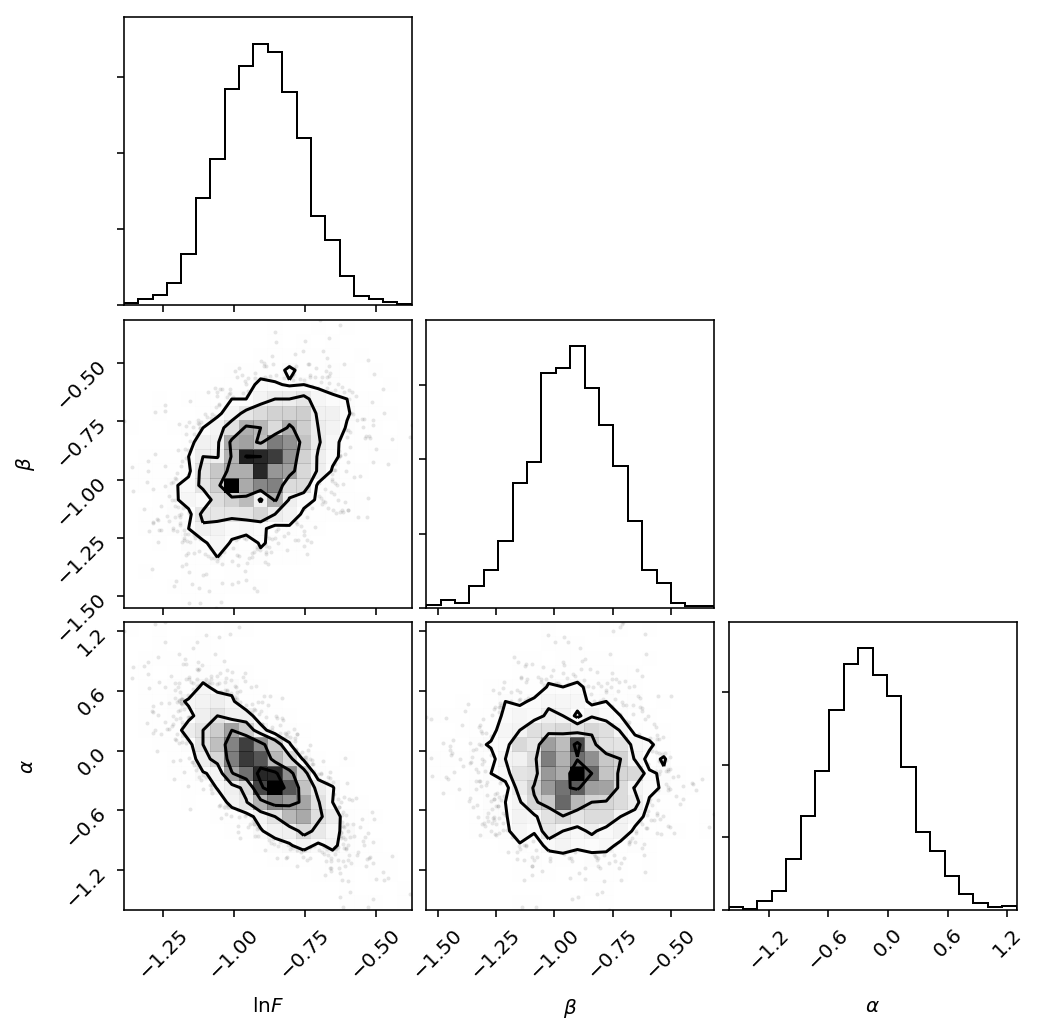

In [293]:


# Make corner plots
corner.corner(np.hstack((lnf0.reshape(-1,1), beta.reshape(-1,1), alpha.reshape(-1,1))), labels=[r"$\ln F$", r"$\beta$", r"$\alpha$"]);

# Examine results
[np.median(alpha), np.median(beta), np.median(lnf0)]
alphaMode = spy.stats.mode(alpha)
betaMode = spy.stats.mode(beta)
lnf0Mode = spy.stats.mode(lnf0)
print(alphaMode)
print(betaMode)
print(lnf0Mode)
print([np.median(alpha), np.median(beta), np.median(lnf0)])

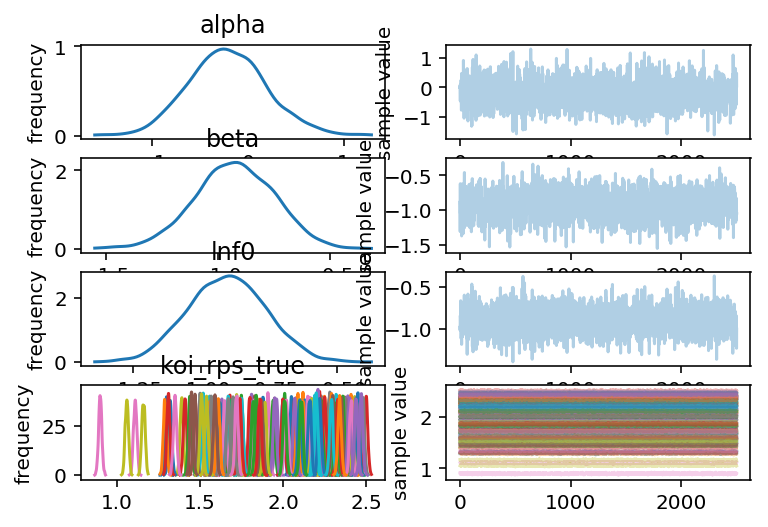

In [294]:
# Plot posterior distributions and trends for parameter samples
fig2 = fit.plot()

In [295]:
## I found Python stan_utility on Jeff Alstott's github: https://github.com/jeffalstott/pystan_time_series
## I am refereing to the Stan Case Studies for HMC diagnostics in pystan:
## http://mc-stan.org/users/documentation/case-studies/pystan_workflow.html

help(stan_utility_copy)

Help on module stan_utility_copy:

NAME
    stan_utility_copy

FILE
    /Users/meganshabram/Dropbox/NASA_Postdoctoral_Program_Fellowship/Stan_Kepler_Populations/stan_utility_copy.py

DESCRIPTION
    #Copyright 2017 Columbia University, 2017 Jeff Alstott
    #
    #Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:
    #
    #1. Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.
    #
    #2. Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution.
    #
    #3. Neither the name of the copyright holder nor the name INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR 

In [296]:
stan_utility_copy.check_treedepth(fit)
stan_utility_copy.check_energy(fit)
stan_utility_copy.check_div(fit)

"1 of 2500 iterations saturated the maximum tree depth of 10 (0%)"
"Run again with max_depth set to a larger value to avoid saturation"
"Chain 0: E-BFMI = 1.34149918503"
"Chain 1: E-BFMI = 1.10318018444"
"Chain 2: E-BFMI = 1.09142995836"
"Chain 3: E-BFMI = 1.00789335477"
"Chain 4: E-BFMI = 0.972749125668"
0.0 of 2500 iterations ended with a divergence (0.0%)


In [297]:
'''
# Archive or retrieve data with pickle

# Stan data to be archived
extract = fit.extract()

# Pickle the data
with open('pystan_results_'+str(nSamplesPerChain)+'_samples_per_chain_'+str(nChains)+'_chains_'+stellarTypeSwitch+'_'+catalogSwitch+'.pkl', 'wb') as handle:
    pickle.dump(extract,handle)
    
# Retrieve pickled data
# with open('pystan_results.pkl', 'rb') as handle:
#      retrieved_results = pickle.load(handle)
#
'''

"\n# Archive or retrieve data with pickle\n\n# Stan data to be archived\nextract = fit.extract()\n\n# Pickle the data\nwith open('pystan_results_'+str(nSamplesPerChain)+'_samples_per_chain_'+str(nChains)+'_chains_'+stellarTypeSwitch+'_'+catalogSwitch+'.pkl', 'wb') as handle:\n    pickle.dump(extract,handle)\n    \n# Retrieve pickled data\n# with open('pystan_results.pkl', 'rb') as handle:\n#      retrieved_results = pickle.load(handle)\n#\n"

In [298]:
#=====================================================================
# Gather and save occurrence rate data for Stan sampler
# Could make this a function which takes as inputs
# the posterior samples array 
# the names of the files to save to
# nSamplesPerChain
# nChains
samples = posteriorSamples

# Define radius and period bin edges
radiusBinEdges = [0.67, 1.0, 1.5, 2.3, 3.4, 5.1, 7.6, 11, 17]
periodBinEdges = [10, 20, 40, 80, 160, 320, 640]

# Initialize dictionary
# occurrenceRateData = dict()

# Initialize lists for median, lower and upper occ rate limits
listMedian = [None]*(len(radiusBinEdges)-1)
listLowerCredibleInterval = [None]*(len(radiusBinEdges)-1)
listUpperCredibleInterval = [None]*(len(radiusBinEdges)-1)

# Loop over desired period and radius bins and compute occurrence rates
for iRadius in range(len(radiusBinEdges)-1):
    # Initialize lists for rows
    listMedianRow = []
    listLowerCredibleIntervalRow = []
    listUpperCredibleIntervalRow = []
    for iPeriod in range(len(periodBinEdges)-1):
        # Integrate the gamma posterior distribution over the selected phase space bin
        # NOTE -- This gives the exoplanet occurrence rate in that phase space bin
        int_gamma_samples = [None]*(len(samples))
        for i, theta in enumerate(samples):
            int_gamma_samples[i] = integrated_gamma(theta,periodBinEdges[iPeriod],periodBinEdges[iPeriod+1],
                                                   radiusBinEdges[iRadius],radiusBinEdges[iRadius+1],periodInsolationSwitch)

        # Print result for this bin
        print("\nRadius Bin "+str(radiusBinEdges[iRadius])+" to "+str(radiusBinEdges[iRadius+1])+" , Period Bin "+str(periodBinEdges[iPeriod])+" to "+str(periodBinEdges[iPeriod+1]))
        print("     Occurrence rate 16, 50, 84 percentile range : {0} ".format(np.percentile(int_gamma_samples,[16,50,84])))

        # Populate the dictionary with the result for this bin
        # binKey = "bin_" + str(radiusBinEdges[iRadius]) + "_" + str(periodBinEdges[iPeriod])
        # occurrenceRateData[binKey] = np.percentile(int_gamma_samples,[16,50,84])
        
        # Accumulate a row vector of median occurrence rates and their upper and lower credible intervals
        # for period bins at this radius
        listMedianRow.append(np.percentile(int_gamma_samples,[50]))
        listLowerCredibleIntervalRow.append(np.percentile(int_gamma_samples,[16]))
        listUpperCredibleIntervalRow.append(np.percentile(int_gamma_samples,[84]))
              
    # Append the row vector of results into the arrays for the median and lower and upper occ rate limits
    listMedian[iRadius] = listMedianRow
    listLowerCredibleInterval[iRadius] = listLowerCredibleIntervalRow
    listUpperCredibleInterval[iRadius] = listUpperCredibleIntervalRow
    
        
# Save the results in a dictionary
# with open('stan_occurrence_rate_data_'+stellarTypeSwitch+'_'+catalogSwitch+'.pkl', 'wb') as handle:
#    pickle.dump(occurrenceRateData, handle)
    
# Save the .csv files
np.savetxt('eta_stan_occurrence_rate_median_'+str(nSamplesPerChain)+'_samples_per_chain_'+str(nChains)+'_chains_'+stellarTypeSwitch+'_'+catalogSwitch+'.csv', np.array(listMedian), delimiter=",",fmt='%.5f')
np.savetxt('sigma_n_stan_occurrence_rate_lower_credible_interval_'+str(nSamplesPerChain)+'_samples_per_chain_'+str(nChains)+'_chains_'+stellarTypeSwitch+'_'+catalogSwitch+'.csv', np.array(listLowerCredibleInterval), delimiter=",",fmt='%.5f')
np.savetxt('sigma_p_stan_occurrence_rate_upper_credible_interval_'+str(nSamplesPerChain)+'_samples_per_chain_'+str(nChains)+'_chains_'+stellarTypeSwitch+'_'+catalogSwitch+'.csv', np.array(listUpperCredibleInterval), delimiter=",",fmt='%.5f')



Radius Bin 0.67 to 1.0 , Period Bin 10 to 20
     Occurrence rate 16, 50, 84 percentile range : [ 0.01769318  0.0283041   0.04490187] 

Radius Bin 0.67 to 1.0 , Period Bin 20 to 40
     Occurrence rate 16, 50, 84 percentile range : [ 0.02017285  0.02973021  0.04437604] 

Radius Bin 0.67 to 1.0 , Period Bin 40 to 80
     Occurrence rate 16, 50, 84 percentile range : [ 0.02182656  0.0313141   0.04501792] 

Radius Bin 0.67 to 1.0 , Period Bin 80 to 160
     Occurrence rate 16, 50, 84 percentile range : [ 0.02322786  0.03338466  0.04721652] 

Radius Bin 0.67 to 1.0 , Period Bin 160 to 320
     Occurrence rate 16, 50, 84 percentile range : [ 0.02332827  0.03557669  0.05154489] 

Radius Bin 0.67 to 1.0 , Period Bin 320 to 640
     Occurrence rate 16, 50, 84 percentile range : [ 0.02275173  0.03724626  0.0581837 ] 

Radius Bin 1.0 to 1.5 , Period Bin 10 to 20
     Occurrence rate 16, 50, 84 percentile range : [ 0.02681522  0.03932517  0.05747469] 

Radius Bin 1.0 to 1.5 , Period Bin 20 to 40

In [299]:
PyStan_flatchain = np.hstack((lnf0.reshape(-1,1), beta.reshape(-1,1), alpha.reshape(-1,1)))
print(PyStan_flatchain.shape)
print(sampler.flatchain.shape)

(2500, 3)
(64000, 3)


16, 50, 84 percentile range for integrated gamma = [ 0.03728442  0.04895297  0.06297783] 


(0, 1)

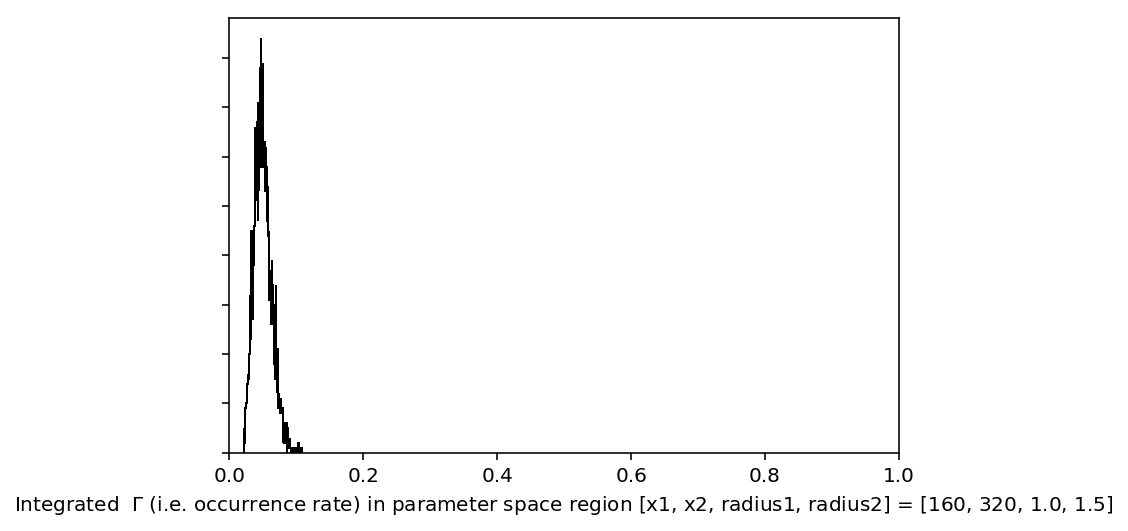

In [300]:
# Integrate the gamma posterior distribution over the selected phase space bin
# NOTE -- This gives the exoplanet occurrence rate in that phase space bin!
int_gamma_samples = np.empty(len(PyStan_flatchain))
for i, theta in enumerate(PyStan_flatchain):
    int_gamma_samples[i] = integrated_gamma(theta,x1,x2,radius1,radius2,periodInsolationSwitch)

# print occurrence rate for this parameter space region
print("16, 50, 84 percentile range for integrated gamma = {0} ".format(np.percentile(int_gamma_samples,[16,50,84])))

# Plot the posterior of int gamma_samples over selected planet radius and period range             
pl.hist(int_gamma_samples, 100, histtype="step", color="k")
pl.gca().set_yticklabels([])
if(periodInsolationSwitch == 'I'):
    pl.title("Integrated ocurrence rate over radius and insolation")
elif(periodInsolationSwitch == 'I'):
    pl.title("Integrated ocurrence rate over radius and period")
    
pl.xlabel(r"Integrated  $\Gamma$ (i.e. occurrence rate) in parameter space region [x1, x2, radius1, radius2] = {0}".format([x1,x2,radius1,radius2]));    
# pl.xlabel(r"$\log_{10}\Gamma_\oplus = \left. \log_{10}\mathrm{d}N / \mathrm{d}\ln P \, \mathrm{d}\ln R_p \right |_\oplus$");
pl.xticks
pl.gca().set_xlim([0,1])


read in previous runs and make a plots with all three results. 

In [326]:
with open('DR25_9.3_occ_rate_1000_no_Runcs3.pkl', 'rb') as handle:
   retrieved_results_no_uncs = pickle.load(handle)

with open('DR25_9.3_occ_rate_1000_neg_Runcs4.pkl', 'rb') as handle2:
   retrieved_results_small_uncs = pickle.load(handle2)

with open('DR25_9.3_occ_rate_40000.pkl', 'rb') as handle3:
   retrieved_results_real_uncs = pickle.load(handle3)


16, 50, 84 percentile range for integrated gamma = [ 0.35180228  0.40451465  0.46755222] 


(0, 1)

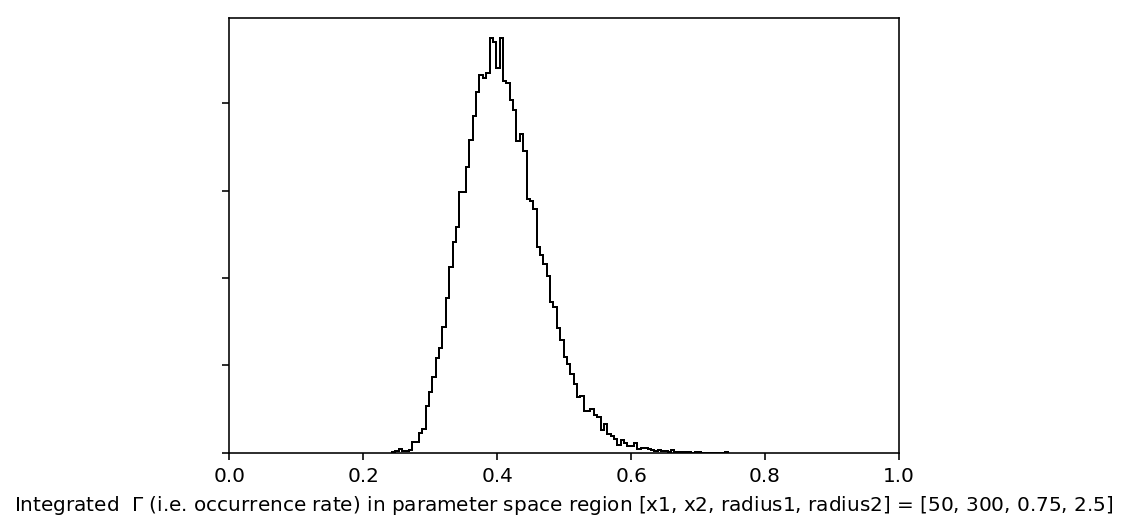

In [364]:
alpha_small = retrieved_results_small_uncs['alpha']
beta_small = retrieved_results_small_uncs['beta']
lnf0_small = retrieved_results_small_uncs['lnf0']

PyStan_flatchain_small_uncs = np.hstack((lnf0_small.reshape(-1,1), beta_small.reshape(-1,1), alpha_small.reshape(-1,1)))

int_gamma_samples_small_uncs = np.empty(len(PyStan_flatchain_small_uncs))
for i, theta in enumerate(PyStan_flatchain_small_uncs):
    int_gamma_samples_small_uncs[i] = integrated_gamma(theta,x1,x2,radius1,radius2,periodInsolationSwitch)

# print occurrence rate for this parameter space region
print("16, 50, 84 percentile range for integrated gamma = {0} ".format(np.percentile(int_gamma_samples,[16,50,84])))

# Plot the posterior of int gamma_samples over selected planet radius and period range             
pl.hist(int_gamma_samples, 100, histtype="step", color="k")
#pl.hist(int_gamma_samples_small_uncs, 100, histtype="step", color="k")
pl.gca().set_yticklabels([])
if(periodInsolationSwitch == 'I'):
    pl.title("Integrated ocurrence rate over radius and insolation")
elif(periodInsolationSwitch == 'I'):
    pl.title("Integrated ocurrence rate over radius and period")
    
pl.xlabel(r"Integrated  $\Gamma$ (i.e. occurrence rate) in parameter space region [x1, x2, radius1, radius2] = {0}".format([x1,x2,radius1,radius2]));    
# pl.xlabel(r"$\log_{10}\Gamma_\oplus = \left. \log_{10}\mathrm{d}N / \mathrm{d}\ln P \, \mathrm{d}\ln R_p \right |_\oplus$");
pl.xticks
pl.gca().set_xlim([0,1])


16, 50, 84 percentile range for integrated gamma = [ 0.35180228  0.40451465  0.46755222] 


(0, 1)

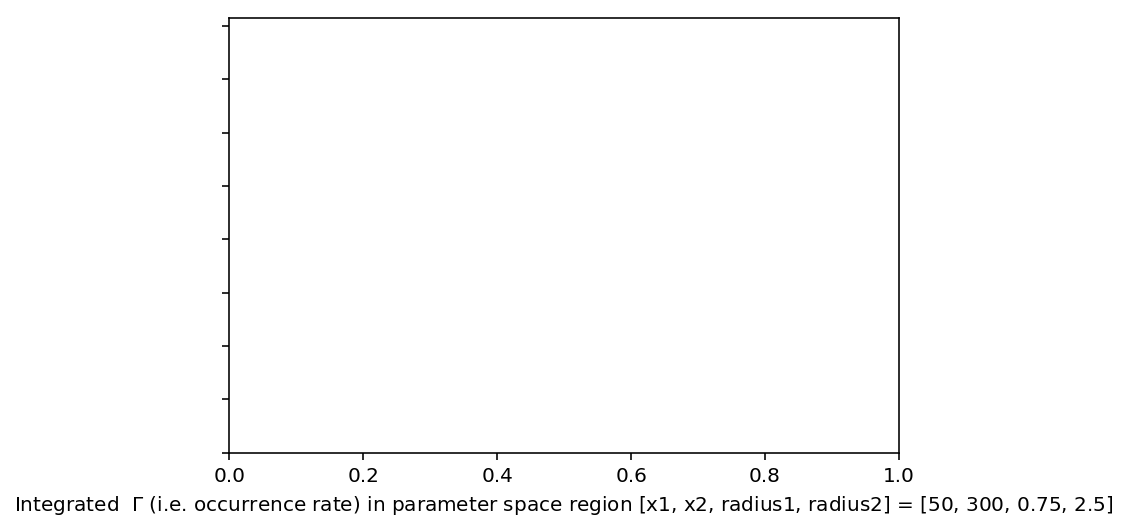

In [365]:
alpha_real = retrieved_results_real_uncs['alpha']
beta_real = retrieved_results_real_uncs['beta']
lnf0_real = retrieved_results_real_uncs['lnf0']

PyStan_flatchain_real_uncs = np.hstack((lnf0_real.reshape(-1,1), beta_real.reshape(-1,1), alpha_real.reshape(-1,1)))

int_gamma_samples_real_uncs = np.empty(len(PyStan_flatchain_real_uncs))
for i, theta in enumerate(PyStan_flatchain_real_uncs):
    int_gamma_samples_real_uncs[i] = integrated_gamma(theta,x1,x2,radius1,radius2,periodInsolationSwitch)

# print occurrence rate for this parameter space region
print("16, 50, 84 percentile range for integrated gamma = {0} ".format(np.percentile(int_gamma_samples,[16,50,84])))

# Plot the posterior of int gamma_samples over selected planet radius and period range             
pl.hist(int_gamma_samples_real_uncs, 100, histtype="step", color="k")
#pl.hist(int_gamma_samples_small_uncs, 100, histtype="step", color="k")
pl.gca().set_yticklabels([])
if(periodInsolationSwitch == 'I'):
    pl.title("Integrated ocurrence rate over radius and insolation")
elif(periodInsolationSwitch == 'I'):
    pl.title("Integrated ocurrence rate over radius and period")
    
pl.xlabel(r"Integrated  $\Gamma$ (i.e. occurrence rate) in parameter space region [x1, x2, radius1, radius2] = {0}".format([x1,x2,radius1,radius2]));    
# pl.xlabel(r"$\log_{10}\Gamma_\oplus = \left. \log_{10}\mathrm{d}N / \mathrm{d}\ln P \, \mathrm{d}\ln R_p \right |_\oplus$");
pl.xticks
pl.gca().set_xlim([0,1])


In [366]:
#pl.hist(int_gamma_samples_no_uncs, 100, histtype="step", color="k")


In [367]:
#pl.hist(int_gamma_samples_real_uncs, 100, histtype="step", color="k")

16, 50, 84 percentile range for integrated gamma = [ 0.35180228  0.40451465  0.46755222] 


(0, 1)

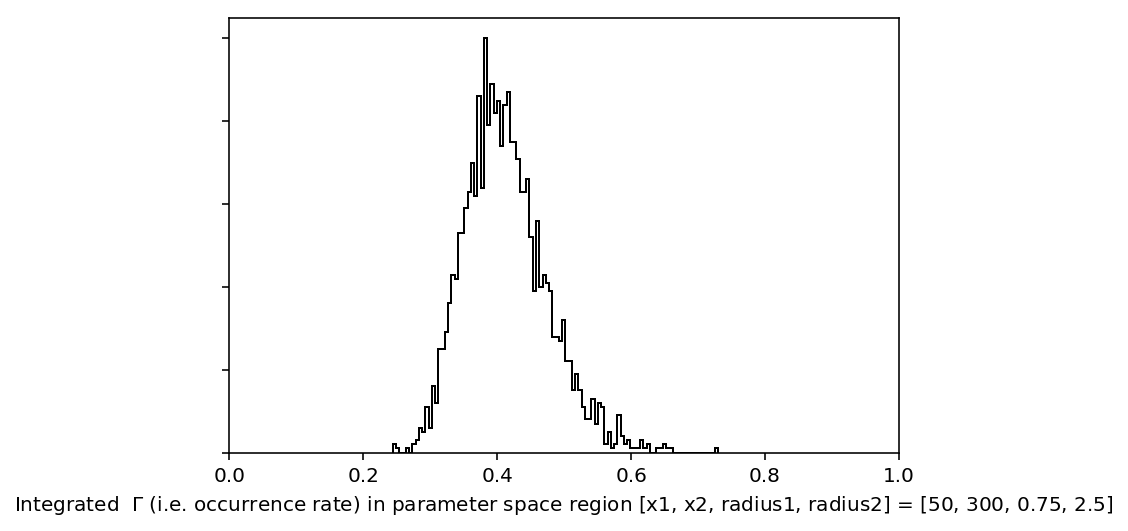

In [368]:
alpha_no = retrieved_results_no_uncs['alpha']
beta_no = retrieved_results_no_uncs['beta']
lnf0_no = retrieved_results_no_uncs['lnf0']

PyStan_flatchain_no_uncs = np.hstack((lnf0_no.reshape(-1,1), beta_no.reshape(-1,1), alpha_no.reshape(-1,1)))

int_gamma_samples_no_uncs = np.empty(len(PyStan_flatchain_no_uncs))
for i, theta in enumerate(PyStan_flatchain_no_uncs):
    int_gamma_samples_no_uncs[i] = integrated_gamma(theta,x1,x2,radius1,radius2,periodInsolationSwitch)

# print occurrence rate for this parameter space region
print("16, 50, 84 percentile range for integrated gamma = {0} ".format(np.percentile(int_gamma_samples,[16,50,84])))

# Plot the posterior of int gamma_samples over selected planet radius and period range             
pl.hist(int_gamma_samples_no_uncs, 100, histtype="step", color="k")
#pl.hist(int_gamma_samples_small_uncs, 100, histtype="step", color="k")
pl.gca().set_yticklabels([])
if(periodInsolationSwitch == 'I'):
    pl.title("Integrated ocurrence rate over radius and insolation")
elif(periodInsolationSwitch == 'I'):
    pl.title("Integrated ocurrence rate over radius and period")
    
pl.xlabel(r"Integrated  $\Gamma$ (i.e. occurrence rate) in parameter space region [x1, x2, radius1, radius2] = {0}".format([x1,x2,radius1,radius2]));    
# pl.xlabel(r"$\log_{10}\Gamma_\oplus = \left. \log_{10}\mathrm{d}N / \mathrm{d}\ln P \, \mathrm{d}\ln R_p \right |_\oplus$");
pl.xticks
pl.gca().set_xlim([0,1])


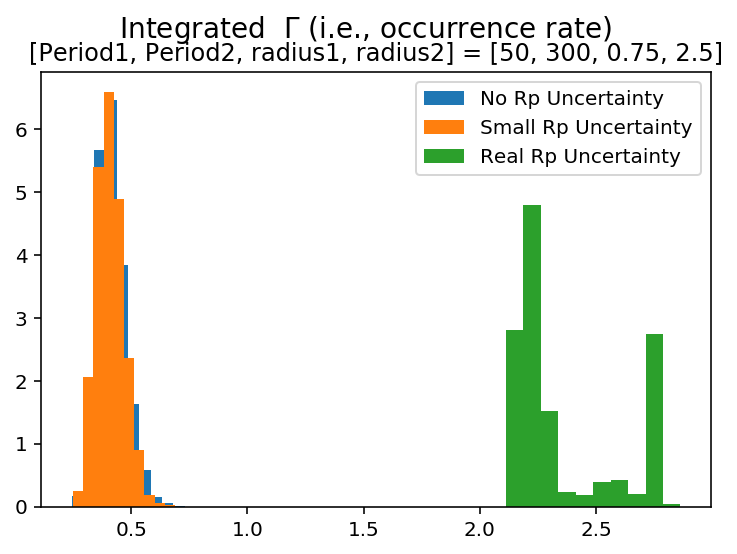

In [369]:
pl.hist(int_gamma_samples_no_uncs, 10, normed='true',label='No Rp Uncertainty')
pl.hist(int_gamma_samples_small_uncs, 10, normed='true',label='Small Rp Uncertainty')
pl.hist(int_gamma_samples_real_uncs, 10, normed='true',label='Real Rp Uncertainty')
pl.suptitle(r"Integrated  $\Gamma$ (i.e., occurrence rate)", fontsize=14)    
pl.title("[Period1, Period2, radius1, radius2] = {0}".format([x1,x2,radius1,radius2]));    
pl.legend()

In [325]:
retrieved_results_no_uncs

Inference for Stan model: anon_model_ec5934bca3a4e83001d1ebcdf23b0052.
5 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2500.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha              -0.21  8.2e-3   0.41  -0.97  -0.49  -0.22   0.05   0.64 2500.0    1.0
beta               -0.93  3.6e-3   0.18  -1.27  -1.04  -0.92   -0.8  -0.59 2500.0    1.0
lnf0                -0.9  2.9e-3   0.14  -1.18   -1.0   -0.9  -0.81  -0.62 2500.0    1.0
koi_rps_true[0]     2.37  2.0e-4 9.8e-3   2.35   2.36   2.37   2.38   2.39 2500.0    1.0
koi_rps_true[1]     2.12  2.0e-4   0.01    2.1   2.11   2.12   2.13   2.14 2500.0    1.0
koi_rps_true[2]     1.75  2.0e-4   0.01   1.73   1.74   1.75   1.76   1.77 2500.0    1.0
koi_rps_true[3]     2.36  2.0e-4 9.9e-3   2.34   2.35   2.36   2.37   2.38 2500.0    1.0
koi_rps_true[4]     2.39  2.0e-410.0e-3   2.37   2.38   2.39    2.4   2.41 2500.0    1.0
koi_rps_true